In [22]:
from video import Video
import visualize
from utils import landmarks_2_table
import mediapipe as mp
import os
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from IPython.display import clear_output, display
import nbimporter
from extract_videos_by_label import get_DESRes_videos_by_label, get_jester_videos_by_label

In [2]:
!pip install mediapipe

Defaulting to user installation because normal site-packages is not writeable


In [3]:
user = "ItayCoifman"
repo = "blazepose-mediapipe-example"
src_dir = "tools"
pyfile = "video.py"
url = f"https://raw.githubusercontent.com/{user}/{repo}/main/{src_dir}/{pyfile}"
!wget --no-cache --backups=1 {url};
pyfile = "visualize.py"
url = f"https://raw.githubusercontent.com/{user}/{repo}/main/{src_dir}/{pyfile}"
!wget --no-cache --backups=1 {url};
pyfile = "utils.py"
url = f"https://raw.githubusercontent.com/{user}/{repo}/main/{src_dir}/{pyfile}"
!wget --no-cache --backups=1 {url};

--2025-12-07 11:39:29--  https://raw.githubusercontent.com/ItayCoifman/blazepose-mediapipe-example/main/tools/video.py
Résolution de raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connexion à raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 7213 (7,0K) [text/plain]
Enregistre : ‘video.py’

video.py            100%[===================>]   7,04K  --.-KB/s    ds 0,01s   

2025-12-07 11:39:29 (529 KB/s) - ‘video.py’ enregistré [7213/7213]

--2025-12-07 11:39:29--  https://raw.githubusercontent.com/ItayCoifman/blazepose-mediapipe-example/main/tools/visualize.py
Résolution de raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connexion à raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443… connecté.
requête HTTP transmise, en attente de la réponse…

In [5]:
def video_pose_estimation_3D(video_path: str, verbose: bool = True):
    """
    Detect 3D BlazePose landmarks from a video and return:
      - marker_df : dataframe with x, y, z coordinates for each keypoint and frame
      - visibility_df : dataframe with landmark visibility values
    """

    output_results = []    # BlazePose outputs
    timestamps = []        # per-frame timestamps (seconds)

    # Load video metadata
    vid = Video.from_path(video_path)
    video_name = os.path.basename(video_path)
    vid_cap = cv2.VideoCapture(vid.path)

    # Display info
    if verbose:
        print(f"Processing video: {video_name}")
        print(f"Resolution: {vid.width}x{vid.height}")
        print(f"Frames: {vid.nFrames}, FPS: {vid.fps}\n")

    # BlazePose model
    with mp.solutions.pose.Pose(
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5
    ) as pose:

        for _ in tqdm(range(vid.nFrames)):
            success, img = vid_cap.read()
            if not success:
                break

            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            timestamps.append(vid_cap.get(cv2.CAP_PROP_POS_MSEC))

            results = pose.process(img_rgb)
            output_results.append(results)

    cv2.destroyAllWindows()

    # Convert to DFs (x,y,z)
    try:
        marker_df, visibility_df = landmarks_2_table(
            output_results,
            time_vec=np.array(timestamps) / 1000.0
        )
    except Exception as e:
        print("⚠️ landmarks_2_table failed:", repr(e))
        print("Returning raw BlazePose outputs.")
        return output_results, None

    return marker_df, visibility_df


In [10]:
videos = get_jester_videos_by_label(label="Stop Sign",n=1)
videos

['Jester_filtered_gestures/Stop Sign/78714.mp4']

In [11]:
marker_df,visibility_df  = video_pose_estimation_3D(video_path = videos[0])

I0000 00:00:1765076204.578644    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765076204.593860    6004 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)


Processing video: 78714.mp4
Resolution: 132x100
Frames: 37, FPS: 12.0



  0%|          | 0/37 [00:00<?, ?it/s]INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1765076204.657041    5986 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765076204.693310    5976 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765076204.708027    5976 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
100%|██████████| 37/37 [00:00<00:00, 40.47it/s]


In [12]:
marker_df.head()

t    nose_x    nose_y    nose_z  left_eye_inner_x  left_eye_inner_y  \
0  0.000000 -0.258943  1.018118  0.011413         -0.244893          1.052966   
1  0.083333 -0.267364  1.032806  0.019131         -0.250217          1.069235   
2  0.166667 -0.272077  1.031859  0.038217         -0.254788          1.068244   
3  0.250000 -0.284719  1.030192  0.035496         -0.269324          1.067162   
4  0.333333 -0.283559  1.028691  0.023158         -0.269504          1.065996   

   left_eye_inner_z  left_eye_x  left_eye_y  left_eye_z  ...  left_heel_z  \
0          0.019126   -0.244302    1.055234    0.019596  ...     0.193900   
1          0.023979   -0.249682    1.071214    0.024280  ...     0.172880   
2          0.039060   -0.254494    1.070284    0.039128  ...     0.174475   
3          0.033145   -0.269332    1.069201    0.032998  ...     0.183722   
4          0.020782   -0.269518    1.068048    0.020639  ...     0.187015   

   right_heel_x  right_heel_y  right_heel_z  left_foot_index_x  \
0     -0.141349      0.326165     -0.006397          -0.252526   
1     -0.097071      0.280744     -0.009278          -0.213024   
2     -0.098696      0.316954     -0.013409          -0.258922   
3     -0.071333      0.315530     -0.008748          -0.258599   
4     -0.073237      0.317287     -0.008270          -0.258042   

   left_foot_index_y  left_foot_index_z  right_foot_index_x  \
0           0.337574           0.295826           -0.537929   
1           0.251970           0.269642           -0.442460   
2           0.355093           0.277459           -0.442995   
3           0.350915           0.283078           -0.414257   
4           0.348896           0.283757           -0.423620   

   right_foot_index_y  right_foot_index_z  
0            0.592843            0.001284  
1            0.523725           -0.002079  
2            0.573986           -0.003768  
3            0.568186            0.000739  
4            0.569247            0.001397  

[5 rows x 100 columns]

In [30]:
from scipy.signal import savgol_filter

def smooth_sequence(data, window=9, poly=3):
    """
    data : (T, D)
    Lisse chaque colonne indépendamment.
    """
    return savgol_filter(data, window_length=window, polyorder=poly, axis=0)

In [31]:
KEYPOINTS = [0, 2, 5, 7, 8, 9, 10, 11, 12] + list(range(13, 25))  # 21 joints (visage + haut du corps)
VIS_THRESH = 0.5  # seuil de visibilité (à ajuster si besoin)

def marker_to_traj_vec_3D(marker_df,
                          visibility_df,
                          keypoints=KEYPOINTS,
                          target_len: int = 50,
                          vis_thresh: float = VIS_THRESH):
    """
    Transforme marker_df + visibility_df en une trajectoire 3D normalisée :

        marker_df : colonnes [t, x_j0, y_j0, z_j0, ..., x_j32, y_j32, z_j32]
        visibility_df : [t, vis_j0, vis_j1, ..., vis_j32]

    Retourne :
        traj_vec : (T, 3 * len(keypoints))  -> typiquement (50, 63)

    Étapes :
      1) Extraction x,y,z
      2) Masquage invisible -> NaN
      3) Interpolation temporelle des NaN
      4) Centrage 3D sur les épaules
      5) Mise à l'échelle par distance épaules-épaule
      6) Interpolation temporelle à target_len frames
      7) Vectorisation -> (T, 3*n_kp)
    """

    # ---- 0) Conversion éventuelle DataFrame -> ndarray ----
    if isinstance(marker_df, pd.DataFrame):
        marker_df = marker_df.to_numpy()
    if isinstance(visibility_df, pd.DataFrame):
        visibility_df = visibility_df.to_numpy()

    T_raw = marker_df.shape[0]
    n_kp = len(keypoints)

    # -------- 1) Récupération du temps --------
    t_src = marker_df[:, 0]

    # -------- 2) Extraction X, Y, Z --------
    seq_xyz = np.zeros((T_raw, n_kp, 3), dtype=float)

    for i, kp in enumerate(keypoints):
        base = 1 + 3 * kp    # x = base, y = base+1, z = base+2
        seq_xyz[:, i, 0] = marker_df[:, base]       # x
        seq_xyz[:, i, 1] = marker_df[:, base + 1]   # y
        seq_xyz[:, i, 2] = marker_df[:, base + 2]   # z

    # -------- 3) Masquage des points invisibles --------
    vis_sel = np.zeros((T_raw, n_kp), dtype=float)
    for i, kp in enumerate(keypoints):
        vis_sel[:, i] = visibility_df[:, 1 + kp]

    mask_invis = (vis_sel < vis_thresh) | ~np.isfinite(vis_sel)
    seq_xyz[mask_invis, :] = np.nan

    # -------- 4) Interpolation temporelle des NaN --------
    seq_flat = seq_xyz.reshape(T_raw, -1)  # (T_raw, 3*n_kp)
    
    seq_flat = smooth_sequence(seq_flat, window=9, poly=3)

    for d in range(seq_flat.shape[1]):
        vals = seq_flat[:, d]
        finite = np.isfinite(vals)
        if finite.sum() >= 2:
            seq_flat[:, d] = np.interp(
                np.arange(T_raw),
                np.arange(T_raw)[finite],
                vals[finite]
            )
        else:
            seq_flat[:, d] = 0.0

    seq_xyz_filled = seq_flat.reshape(T_raw, n_kp, 3)

    # -------- 5) Normalisation par les épaules en 3D --------
    try:
        idx_sh_l = keypoints.index(11)
        idx_sh_r = keypoints.index(12)
    except ValueError:
        raise ValueError("KEYPOINTS doit contenir 11 et 12 (épaules).")

    shoulder_L = seq_xyz_filled[:, idx_sh_l, :]  # (T_raw, 3)
    shoulder_R = seq_xyz_filled[:, idx_sh_r, :]

    # Centrage 3D
    centers = 0.5 * (shoulder_L + shoulder_R)
    seq_centered = seq_xyz_filled - centers[:, None, :]   # (T_raw, n_kp, 3)

    # Échelle = distance 3D épaules-épaules
    shoulder_dist = np.linalg.norm(shoulder_R - shoulder_L, axis=1)

    finite_sd = shoulder_dist[np.isfinite(shoulder_dist) & (shoulder_dist > 1e-6)]
    scale = np.mean(finite_sd) if finite_sd.size > 0 else 1.0

    seq_norm = seq_centered / scale

    # -------- 6) Interpolation temporelle à target_len --------
    if target_len and target_len > 0:
        t_new = np.linspace(t_src[0], t_src[-1], target_len)
        seq_norm_flat = seq_norm.reshape(T_raw, -1)     # (T_raw, 3*n_kp)
        seq_resampled_flat = np.zeros((target_len, seq_norm_flat.shape[1]))

        for d in range(seq_norm_flat.shape[1]):
            seq_resampled_flat[:, d] = np.interp(t_new, t_src, seq_norm_flat[:, d])

        seq_resampled = seq_resampled_flat.reshape(target_len, n_kp, 3)
        T_out = target_len
    else:
        seq_resampled = seq_norm
        T_out = T_raw

    # -------- 7) Vectorisation finale pour DMP --------
    traj_vec = seq_resampled.reshape(T_out, n_kp * 3)  # (T_out, 63)

    return traj_vec


In [15]:
class DMPVector:
    def __init__(self, n_basis: int = 20):
        self.n_basis = n_basis #number of gaussians
        self.centers = None
        self.widths = None
        self.W = None       # (n_basis, D)
        self.y0 = None      # (D,)
        self.g = None       # (D,)
        self.T_train = None

    #define each psi function
    def _basis_functions(self, T: int):
        t = np.linspace(0.0, 1.0, T)
        self.centers = np.linspace(0.0, 1.0, self.n_basis)
        self.widths = np.ones(self.n_basis) * (self.n_basis ** 2)
        psi = np.exp(-self.widths * (t[:, None] - self.centers[None, :])**2)
        return psi, t

    def fit(self, Y: np.ndarray):
        T, D = Y.shape
        self.T_train = T
        self.y0 = Y[0].copy()
        self.g  = Y[-1].copy()     #goal point for each trajectory

        psi, t = self._basis_functions(T)   # psi: (T, n_basis)

        # Composante linéaire entre y0 et g pour chaque dimension
        Y_lin = self.y0 + np.outer(t, (self.g - self.y0))   # (T, D)

        # Composante non linéaire à approximer
        F_target = Y - Y_lin                                # (T, D)

        # Normalisation des bases
        psi_sum  = np.sum(psi, axis=1, keepdims=True) + 1e-10
        psi_norm = psi / psi_sum                           # (T, n_basis)

        # Résolution des poids W dans F_target ≈ psi_norm @ W
        # psi_norm: (T, n_basis), F_target: (T, D) -> W: (n_basis, D)
        self.W, _, _, _ = np.linalg.lstsq(psi_norm, F_target, rcond=None)

    def fit_multi(self, Y_batch: np.ndarray):
        """
        Y_batch : (N, T, D) — ensemble de N démos pour un même geste
        Apprend un seul W en empilant toutes les F_target.
        """
        N, T, D = Y_batch.shape
        self.T_train = T

        # base functions communes
        psi, t = self._basis_functions(T)           # (T, n_basis)
        psi_sum  = np.sum(psi, axis=1, keepdims=True) + 1e-10
        psi_norm = psi / psi_sum                    # (T, n_basis)

        # On va empiler toutes les F_target
        F_list = []

        # Pour la partie linéaire de référence, on choisit les moyennes des y0, g
        y0_all = []
        g_all  = []

        for i in range(N):
            Y = Y_batch[i]              # (T, D)
            y0_i = Y[0].copy()
            g_i  = Y[-1].copy()

            y0_all.append(y0_i)
            g_all.append(g_i)

            Y_lin_i = y0_i + np.outer(t, (g_i - y0_i))   # (T, D)
            F_i     = Y - Y_lin_i                        # (T, D)
            F_list.append(F_i)

        # Empilement
        F_all = np.concatenate(F_list, axis=0)           # (N*T, D)
        Psi_big = np.tile(psi_norm, (N, 1))              # (N*T, n_basis)

        # Régression globale
        self.W, _, _, _ = np.linalg.lstsq(Psi_big, F_all, rcond=None)

        # y0, g moyens pour ce geste
        self.y0 = np.mean(np.stack(y0_all, axis=0), axis=0)  # (D,)
        self.g  = np.mean(np.stack(g_all, axis=0),  axis=0)  # (D,)


    def rollout(self, T: int = None, amplitude_scale: float = 1.0) -> np.ndarray:
        """
        Génère une nouvelle trajectoire :
        - T : nombre de pas (si None -> même T que l'entraînement)
        - amplitude_scale : scaling global de la partie non-linéaire
        Retour : (T, D)
        """
        if T is None:
            T = self.T_train

        psi, t = self._basis_functions(T)
        psi_sum  = np.sum(psi, axis=1, keepdims=True) + 1e-10
        psi_norm = psi / psi_sum

        # F: (T, D)
        F = psi_norm @ self.W * amplitude_scale

        # partie linéaire entre y0 et g
        Y_lin = self.y0 + np.outer(t, (self.g - self.y0))

        Y = Y_lin + F
        return Y


In [17]:
labels_DESRes = ['one', 'finger', 'cup', 'knock', 'clasp', 'hold', 'punch', 'point', 'wave', 'show', 'soft', 'present', 'hand']

labels_jester = ['Stop Sign', 'Drumming Fingers', 'Thumb Up', 'Thumb Down', 'Turning Hand Counterclockwise', 'Turning Hand Clockwise', 
                 'Rolling Hand Backward', 'Rolling Hand Forward', 'Pushing Hand Away', 'Shaking Hand']

def build_gesture_dataset(label, n, target_len=50):
    
    if label in labels_DESRes:
        video_paths = get_DESRes_videos_by_label(label, n)
    elif label in labels_jester:
        video_paths = get_jester_videos_by_label(label, n)
    else:
        raise ValueError(f"❌ Label '{label}' non reconnu.")
    
    X = []

    for vp in video_paths:
        try:
            # version 3D → ne renvoie que (marker_df, visibility_df)
            marker_df, visibility_df = video_pose_estimation_3D(
                vp, verbose=False
            )

            traj = marker_to_traj_vec_3D(
                marker_df,
                visibility_df,
                target_len=target_len
            )

            X.append(traj)

        except Exception as e:
            print(f"⚠️ Skip {vp} : {repr(e)}")

    if len(X) == 0:
        raise RuntimeError(
            f"❌ Aucune trajectoire n'a pu être extraite pour le label '{label}'."
        )

    X = np.stack(X, axis=0)  # → (N, T, 63)
    return X, video_paths



In [ ]:
X_point, vids_point = build_gesture_dataset("point", 10, target_len=50)
X_point.shape

In [ ]:
gesture_dmps = {}

labels = labels_DESRes + labels_jester

for lab in labels:
    X_lab, vids_lab = build_gesture_dataset(lab, n=100, target_len=50)
    dmp = DMPVector(n_basis=20)
    dmp.fit_multi(X_lab)
    gesture_dmps[lab] = dmp

In [20]:
import joblib

# Sauvegarde dans un fichier binaire
joblib.dump(gesture_dmps, "gesture_dmps_3D.joblib")

print("✔️ DMPs saved !")

✔️ DMPs saved !


In [37]:
def evaluate_dmp_reconstruction(dmp, X_batch):
    """
    X_batch : (N, T, D)
    Retourne :
    - rmse_all : (N,) RMSE globale par démo
    - rmse_per_frame : (N, T) RMSE par frame
    """
    N, T, D = X_batch.shape

    # Reconstructions
    Y_hat = np.zeros_like(X_batch)

    for i in range(N):
        Y_hat[i] = dmp.rollout(T=T)  # Reconstruction DMP

    err = X_batch - Y_hat  # (N, T, D)

    rmse_per_frame = np.sqrt(np.mean(err**2, axis=2))  # (N, T)
    rmse_all = np.sqrt(np.mean(err**2, axis=(1,2)))    # (N,)
    rsme_mean = rmse_all.mean()

    return rmse_all, rmse_per_frame, rsme_mean

In [40]:
def analyse_label_filtered(label, 
                           n=100, 
                           target_len=50, 
                           n_basis=30, 
                           rmse_threshold=0.35):

    # 1) Dataset
    X_raw, vids_raw = build_gesture_dataset(label, n=n, target_len=target_len)
    N_raw = len(X_raw)

    print(f"\n🔎 {label} : {N_raw} videos loaded")

    # 2) DMP multi-démos
    dmp_full = DMPVector(n_basis=n_basis)
    dmp_full.fit_multi(X_raw)

    # 3) RMSE multi-démos
    rmse_all, rmse_per_frame, rmse_mean = evaluate_dmp_reconstruction(dmp_full, X_raw)

    print(f"📊 Mean RMSE (filtered)  : {rmse_mean:.4f}")
    print(f"📈 RMSE max : {rmse_all.max():.4f}")

    # 4) Filtrage basé sur RMSE multi-démos
    keep_mask = rmse_all < rmse_threshold
    print(f"🧹 Filtrage : {keep_mask.sum()}/{len(keep_mask)} vidéos gardées (< {rmse_threshold})")

    X = X_raw[keep_mask]
    vids = [vids_raw[i] for i in range(N_raw) if keep_mask[i]]   # ⭐ CORRECTIF ICI ⭐

    if len(X) == 0:
        print("⚠️ Aucune vidéo n'a passé le filtrage pour ce label. Analyse ignorée.")
        return None, None, None, None, []


    # 5) Réentraîner le DMP multi-démos
    dmp = DMPVector(n_basis=n_basis)
    dmp.fit_multi(X)

    # 6) RMSE final
    rmse_all_f, rmse_per_frame_f, rmse_mean_f = evaluate_dmp_reconstruction(dmp, X)

    print("\n📊 Mean RMSE (filtered) :", rmse_mean_f)
    print("📈 RMSE max :", rmse_all_f.max())
    print("📉 RMSE min :", rmse_all_f.min())

    # Plot
    plt.figure(figsize=(10, 5))
    for i in range(rmse_per_frame_f.shape[0]):
        plt.plot(rmse_per_frame_f[i], alpha=0.25)

    plt.plot(rmse_per_frame_f.mean(axis=0), color='red', linewidth=3, label='Moyenne')

    plt.title(f"RMSE per frame for '{label}' (filtered)")
    plt.xlabel("Frame")
    plt.ylabel("RMSE")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()

    return rmse_all_f, rmse_per_frame_f, dmp, X, vids, rmse_all


In [ ]:
analyse_label_filtered("Shaking Hand")

I0000 00:00:1765095285.991183    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765095285.992042  283613 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)


⚠️ Seulement 1 vidéos disponibles pour 'one', mais 100 demandées.
👉 Retour de TOUTES les vidéos disponibles.


  0%|          | 0/313 [00:00<?, ?it/s]W0000 00:00:1765095286.081292  283608 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765095286.096741  283605 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 313/313 [00:07<00:00, 43.44it/s]



🔎 one : 1 videos loaded
📊 Mean RMSE (filtered)  : 0.0235
📈 RMSE max : 0.0235
🧹 Filtrage : 1/1 vidéos gardées (< 0.35)

📊 Mean RMSE (filtered) : 0.023534900587109272
📈 RMSE max : 0.023534900587109272
📉 RMSE min : 0.023534900587109272


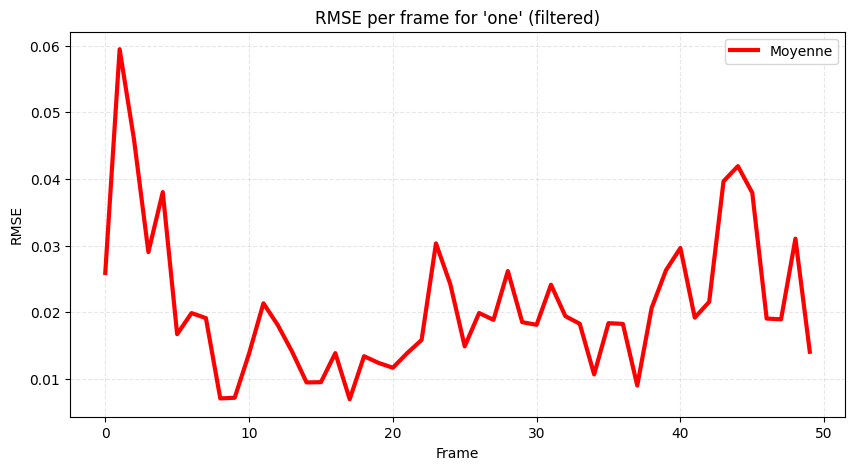

I0000 00:00:1765095293.331945    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.0235349]), array([[0.02589312, 0.0594506 , 0.04590394, 0.02901972, 0.03801274,
        0.01669188, 0.01986327, 0.01910574, 0.00705876, 0.0071546 ,
        0.01377685, 0.02132605, 0.01806148, 0.0140467 , 0.00945896,
        0.00949429, 0.01385746, 0.00693737, 0.01339174, 0.01239429,
        0.01166142, 0.01385548, 0.01582557, 0.03032157, 0.02417207,
        0.01487156, 0.01987143, 0.01884239, 0.02617072, 0.01849392,
        0.01810342, 0.02411822, 0.01940096, 0.01826017, 0.01065612,
        0.01835121, 0.01823946, 0.00899429, 0.02062967, 0.02629772,
        0.02962827, 0.01917765, 0.02153655, 0.03964163, 0.0419099 ,
        0.03790055, 0.01903741, 0.01893184, 0.03102895, 0.01405596]]), <__main__.DMPVector object at 0x7df5f90bc310>, array([[[-0.62092377,  0.38781025,  0.08199406, ...,  0.04935173,
         -1.3695751 , -0.23016029],
        [-0.60285549,  0.37197794,  0.05729167, ..., -0.31363306,
         -1.37138482, -0.18880654],
        [-0.58230854,  0.37951447,  0.1074022

I0000 00:00:1765095293.332995  283665 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/88 [00:00<?, ?it/s]W0000 00:00:1765095293.386698  283650 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765095293.414908  283658 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 88/88 [00:02<00:00, 42.13it/s]


🔎 finger : 1 videos loaded
📊 Mean RMSE (filtered)  : 0.0019
📈 RMSE max : 0.0019
🧹 Filtrage : 1/1 vidéos gardées (< 0.35)

📊 Mean RMSE (filtered) : 0.0019241473507938458
📈 RMSE max : 0.0019241473507938458
📉 RMSE min : 0.0019241473507938458


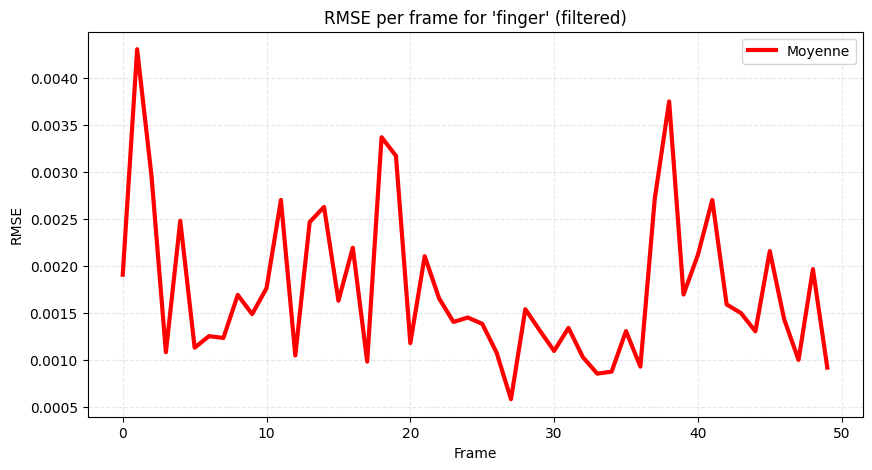

I0000 00:00:1765095295.529034    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.00192415]), array([[0.00190527, 0.00430812, 0.00295665, 0.00107945, 0.00248035,
        0.00112823, 0.00125082, 0.00123166, 0.00169045, 0.00148536,
        0.00176271, 0.00270216, 0.00104486, 0.00246632, 0.00262755,
        0.00162815, 0.00219289, 0.00097941, 0.0033702 , 0.00317242,
        0.00117651, 0.00210299, 0.00165323, 0.00140226, 0.00144902,
        0.00138227, 0.00107529, 0.00057869, 0.00153776, 0.00131152,
        0.0010931 , 0.00133855, 0.00102662, 0.00085148, 0.00087244,
        0.00130478, 0.00092607, 0.00271387, 0.00375185, 0.00169476,
        0.00211653, 0.00270178, 0.0015886 , 0.00149599, 0.00130151,
        0.00215694, 0.00143124, 0.0009974 , 0.00196452, 0.00091564]]), <__main__.DMPVector object at 0x7df5d0f2d300>, array([[[-0.62375572,  0.45604998,  0.00987919, ...,  0.30882303,
         -1.31521108, -0.48917523],
        [-0.65087605,  0.45992275,  0.0072343 , ...,  0.26254527,
         -1.31554104, -0.45789528],
        [-0.67169259,  0.45524578,  0.006734

I0000 00:00:1765095295.529968  283716 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/33 [00:00<?, ?it/s]W0000 00:00:1765095295.580670  283699 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765095295.606572  283711 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 33/33 [00:00<00:00, 43.00it/s]
I0000 00:00:1765095296.317896    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765095296.318658  283767 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/24 [00:00<?, ?it/s]W0000 00:00:1765095296.365437  283762 inference_feedback_manager.cc:114] Feedba


🔎 cup : 8 videos loaded
📊 Mean RMSE (filtered)  : 0.1173
📈 RMSE max : 0.1917
🧹 Filtrage : 8/8 vidéos gardées (< 0.35)

📊 Mean RMSE (filtered) : 0.11729157097888601
📈 RMSE max : 0.1917393651245368
📉 RMSE min : 0.06361571137196456


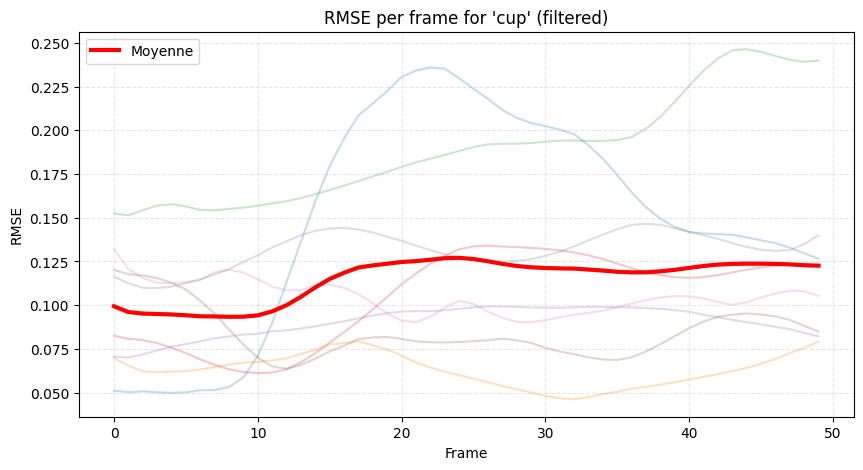

I0000 00:00:1765095302.579035    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765095302.580025  284124 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)


(array([0.16171576, 0.06361571, 0.19173937, 0.10783913, 0.09071246,
       0.08563036, 0.10503369, 0.13204609]), array([[0.0510913 , 0.0501569 , 0.05074408, 0.05011354, 0.04981429,
        0.05014489, 0.0513375 , 0.05142872, 0.05322107, 0.05859075,
        0.07090494, 0.08985632, 0.11318573, 0.13638978, 0.15942993,
        0.1796003 , 0.19530199, 0.2086138 , 0.21534667, 0.22248088,
        0.23051631, 0.23423349, 0.23597706, 0.23534336, 0.22977131,
        0.22384569, 0.21800113, 0.21175388, 0.20723458, 0.20422641,
        0.2024026 , 0.20040264, 0.1978355 , 0.19137349, 0.18381854,
        0.17442336, 0.16453417, 0.15601307, 0.14946913, 0.14479438,
        0.14180995, 0.14100555, 0.14056682, 0.14025788, 0.13874124,
        0.13710392, 0.13548944, 0.13287098, 0.12969435, 0.12649741],
       [0.06976732, 0.06538789, 0.06217159, 0.06164186, 0.06204563,
        0.06220727, 0.06321674, 0.06451456, 0.06600113, 0.06702217,
        0.06753333, 0.068421  , 0.06955366, 0.07203175, 0.07451867,
  

  0%|          | 0/52 [00:00<?, ?it/s]W0000 00:00:1765095302.621247  284108 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765095302.651498  284119 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 52/52 [00:01<00:00, 43.10it/s]


🔎 knock : 1 videos loaded
📊 Mean RMSE (filtered)  : 0.0009
📈 RMSE max : 0.0009
🧹 Filtrage : 1/1 vidéos gardées (< 0.35)

📊 Mean RMSE (filtered) : 0.0008600891060738965
📈 RMSE max : 0.0008600891060738965
📉 RMSE min : 0.0008600891060738965


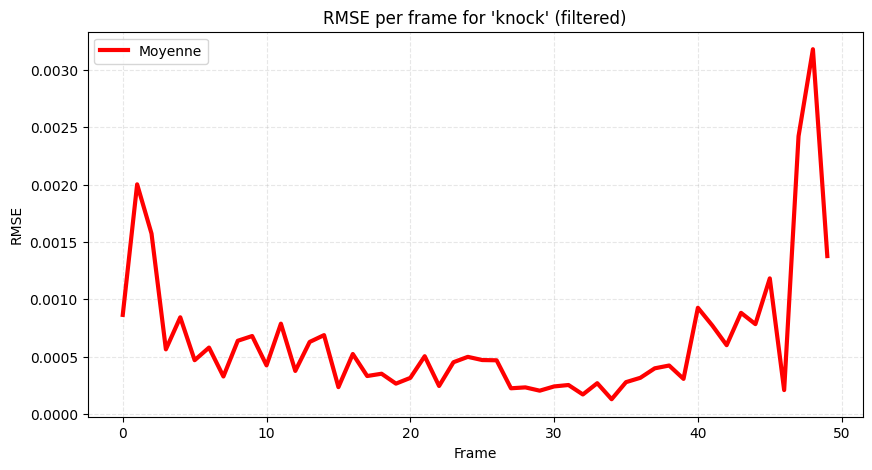

(array([0.00086009]), array([[0.00086291, 0.00200134, 0.00157199, 0.00056245, 0.00084197,
        0.00046782, 0.00057802, 0.00032602, 0.00063735, 0.00067864,
        0.0004229 , 0.00078662, 0.00037432, 0.00062719, 0.00068664,
        0.00023306, 0.00052186, 0.00032993, 0.00034995, 0.00026365,
        0.00031367, 0.00050261, 0.00024315, 0.00045021, 0.00049707,
        0.0004693 , 0.00046708, 0.00022308, 0.00023088, 0.00020217,
        0.00023916, 0.00025157, 0.00016904, 0.00026735, 0.00012766,
        0.00027655, 0.00031459, 0.00039709, 0.00042154, 0.0003052 ,
        0.000925  , 0.00077094, 0.00059902, 0.00088096, 0.00078252,
        0.00118132, 0.00020735, 0.00242137, 0.00317966, 0.00137592]]), <__main__.DMPVector object at 0x7df5d0fa8670>, array([[[-0.5689414 ,  0.41056221,  0.06052569, ...,  0.1847674 ,
         -1.28744905, -0.26051644],
        [-0.55982492,  0.42337947,  0.06948965, ...,  0.19075484,
         -1.30397618, -0.25308601],
        [-0.55647161,  0.43028201,  0.080496

I0000 00:00:1765095303.892365    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/30 [00:00<?, ?it/s]I0000 00:00:1765095303.893241  284175 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765095303.953286  284157 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765095303.987169  284172 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 30/30 [00:00<00:00, 43.38it/s]
I0000 00:00:1765095304.606885    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765095304.607742  284226 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   


🔎 clasp : 5 videos loaded
📊 Mean RMSE (filtered)  : 0.0595
📈 RMSE max : 0.0772
🧹 Filtrage : 5/5 vidéos gardées (< 0.35)

📊 Mean RMSE (filtered) : 0.059517816695309964
📈 RMSE max : 0.0772388998162976
📉 RMSE min : 0.042080075246405745


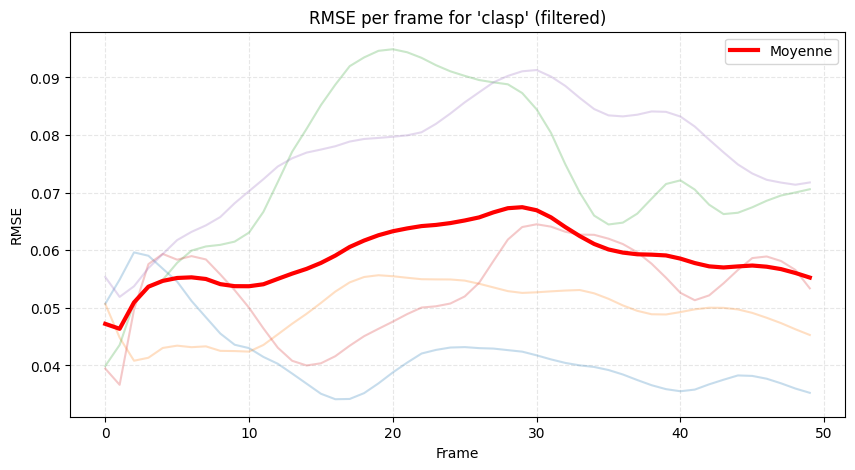

I0000 00:00:1765095308.772459    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.04208008, 0.04967857, 0.07472296, 0.05386858, 0.0772389 ]), array([[0.05069832, 0.05489293, 0.05962591, 0.05904386, 0.05679606,
        0.05455504, 0.05119072, 0.04835217, 0.04553692, 0.04358828,
        0.04300245, 0.04147006, 0.04028575, 0.03858063, 0.03683164,
        0.03507629, 0.03412668, 0.03417134, 0.0351816 , 0.03687573,
        0.03877609, 0.0404871 , 0.04206394, 0.04269042, 0.04310291,
        0.04317733, 0.04300014, 0.04292198, 0.04265249, 0.04238747,
        0.04175124, 0.04104418, 0.04042966, 0.04000564, 0.03973071,
        0.03919864, 0.03842202, 0.03746065, 0.03655763, 0.03587521,
        0.03551114, 0.03579793, 0.03671329, 0.03751004, 0.03825752,
        0.03817382, 0.03768798, 0.03688823, 0.03597948, 0.03523653],
       [0.0506802 , 0.04482276, 0.04081185, 0.04132795, 0.04303007,
        0.04342948, 0.04316424, 0.04330878, 0.04252564, 0.04249066,
        0.04239117, 0.04355229, 0.04538363, 0.04724009, 0.0489611 ,
        0.05084568, 0.05281984, 0.05441922, 0

I0000 00:00:1765095308.773519  284430 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/139 [00:00<?, ?it/s]W0000 00:00:1765095308.816731  284418 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765095308.836046  284426 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 139/139 [00:03<00:00, 45.48it/s]
I0000 00:00:1765095311.865931    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765095311.867011  284481 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/103 [00:00<?, ?it/s]W0000 00:00:1765095311.906839  284468 inference_feedback_manager.cc:114] Fe

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip GESRes_filtered_gestures/hold/2099_Lecturer3_hold_close.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765095323.989198  284737 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/62 [00:00<?, ?it/s]W0000 00:00:1765095324.023933  284719 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765095324.047051  284731 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 62/62 [00:01<00:00, 43.23it/s]
I0000 00:00:1765095325.443553    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765095325.444359  284789 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/93 [00:00<?, ?it/s]W0000 00:00:1765095325.490908  284772 inference_feedback_manager.cc:114] Feedba


🔎 hold : 99 videos loaded
📊 Mean RMSE (filtered)  : 0.1950
📈 RMSE max : 1.1622
🧹 Filtrage : 94/99 vidéos gardées (< 0.35)

📊 Mean RMSE (filtered) : 0.16300464930287117
📈 RMSE max : 0.34893957378246016
📉 RMSE min : 0.0751027627257098


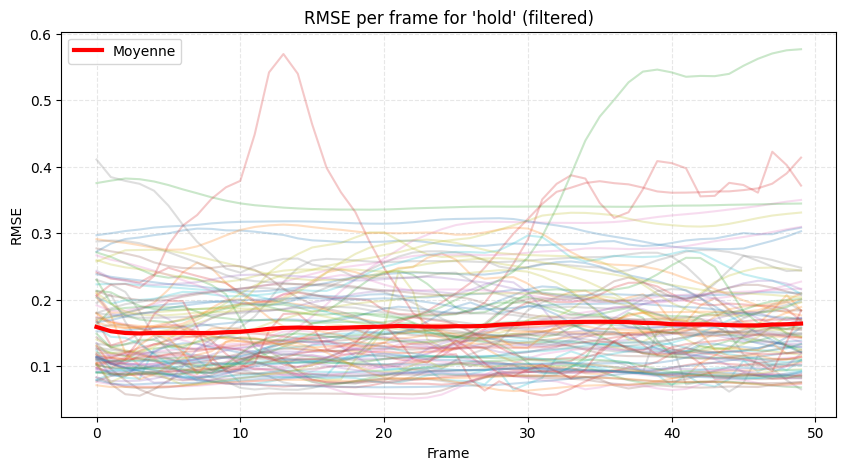

I0000 00:00:1765095481.844121    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.29083517, 0.21542711, 0.18879811, 0.28583734, 0.12924778,
       0.08860633, 0.26847465, 0.22599993, 0.15311988, 0.09468928,
       0.17089028, 0.27586717, 0.16234966, 0.26545642, 0.14176146,
       0.07510276, 0.13652372, 0.12787421, 0.14892885, 0.24260269,
       0.20272282, 0.1618094 , 0.13320873, 0.08646857, 0.12951237,
       0.12410249, 0.14577534, 0.24139927, 0.22923226, 0.16443099,
       0.2229032 , 0.14244709, 0.16782682, 0.15811634, 0.22216953,
       0.08908536, 0.21692413, 0.23078793, 0.27382909, 0.11954691,
       0.30594331, 0.16155898, 0.34605527, 0.10480974, 0.09621919,
       0.16780742, 0.10957751, 0.10610299, 0.21560145, 0.12963571,
       0.14550176, 0.12696901, 0.09439836, 0.25769313, 0.1480438 ,
       0.142401  , 0.10411971, 0.16269365, 0.17662343, 0.09923243,
       0.0866182 , 0.10804907, 0.15875287, 0.11904328, 0.1658045 ,
       0.08266123, 0.25582183, 0.19567819, 0.24311794, 0.11730664,
       0.08623015, 0.07768661, 0.34893957, 0.1052296 , 0.0889

I0000 00:00:1765095481.844938  289560 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/19 [00:00<?, ?it/s]W0000 00:00:1765095481.884710  289544 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765095481.908937  289553 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 19/19 [00:00<00:00, 38.01it/s]



🔎 punch : 1 videos loaded
📊 Mean RMSE (filtered)  : 0.0001
📈 RMSE max : 0.0001
🧹 Filtrage : 1/1 vidéos gardées (< 0.35)

📊 Mean RMSE (filtered) : 0.00013795267839042527
📈 RMSE max : 0.00013795267839042527
📉 RMSE min : 0.00013795267839042527


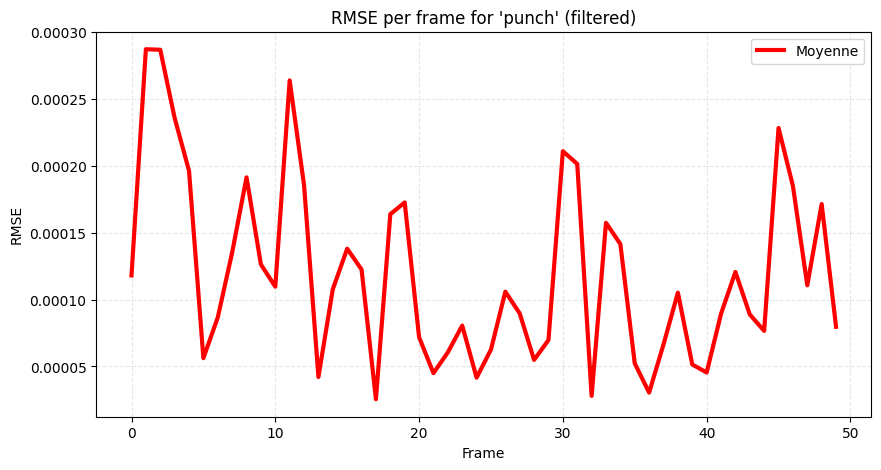

I0000 00:00:1765095482.447494    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765095482.448486  289611 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)


(array([0.00013795]), array([[1.18147893e-04, 2.87375509e-04, 2.86971613e-04, 2.35961037e-04,
        1.96404061e-04, 5.62610645e-05, 8.67535066e-05, 1.35226585e-04,
        1.91498945e-04, 1.26353758e-04, 1.09702234e-04, 2.64021369e-04,
        1.85706306e-04, 4.21526036e-05, 1.07793681e-04, 1.38121252e-04,
        1.22566627e-04, 2.55039774e-05, 1.63955485e-04, 1.72719861e-04,
        7.19366996e-05, 4.50287910e-05, 6.05606647e-05, 8.06079350e-05,
        4.16470873e-05, 6.26447354e-05, 1.05949867e-04, 8.96760601e-05,
        5.49342683e-05, 6.98046649e-05, 2.11067816e-04, 2.01556552e-04,
        2.79937713e-05, 1.57506418e-04, 1.41554747e-04, 5.23091677e-05,
        3.04540845e-05, 6.65295688e-05, 1.05229886e-04, 5.15089238e-05,
        4.54617082e-05, 8.93773279e-05, 1.20730282e-04, 8.89268280e-05,
        7.66245168e-05, 2.28451208e-04, 1.85089500e-04, 1.10738728e-04,
        1.71509965e-04, 7.97044310e-05]]), <__main__.DMPVector object at 0x7df6a5046620>, array([[[-0.46170817,  0

  0%|          | 0/42 [00:00<?, ?it/s]W0000 00:00:1765095482.516479  289595 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765095482.539730  289603 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 42/42 [00:01<00:00, 39.60it/s]
I0000 00:00:1765095483.535988    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765095483.537147  289662 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/32 [00:00<?, ?it/s]W0000 00:00:1765095483.597198  289649 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765095483.621051  289656 inference_feedback_ma


🔎 point : 18 videos loaded
📊 Mean RMSE (filtered)  : 0.4889
📈 RMSE max : 0.8487
🧹 Filtrage : 5/18 vidéos gardées (< 0.35)

📊 Mean RMSE (filtered) : 0.20826183334930665
📈 RMSE max : 0.3174272422420692
📉 RMSE min : 0.1533437587917068


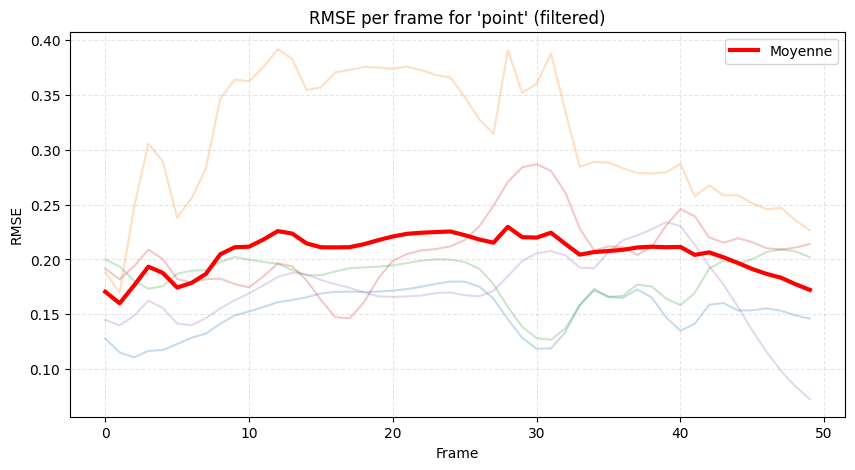

I0000 00:00:1765095506.906451    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.15334376, 0.31742724, 0.18458757, 0.2109846 , 0.174966  ]), array([[0.1276669 , 0.11517644, 0.11049408, 0.11642684, 0.11723832,
        0.1228273 , 0.12844885, 0.13232951, 0.14119136, 0.14881487,
        0.15244681, 0.15651858, 0.16097081, 0.16293678, 0.16549499,
        0.16887648, 0.17033636, 0.17054035, 0.17032956, 0.17065355,
        0.17148275, 0.1729575 , 0.17512334, 0.17773126, 0.17978578,
        0.17970406, 0.17528341, 0.1642822 , 0.14540033, 0.12836067,
        0.11849507, 0.118742  , 0.13357796, 0.15830918, 0.17302928,
        0.16574687, 0.16483246, 0.17268202, 0.1653735 , 0.14718399,
        0.13484834, 0.14133795, 0.15865103, 0.160179  , 0.15330238,
        0.15351419, 0.15535913, 0.15318279, 0.14898756, 0.14590682],
       [0.18844083, 0.16965011, 0.24753749, 0.30571154, 0.28957984,
        0.2381829 , 0.25570938, 0.28320605, 0.34690911, 0.36414003,
        0.36259285, 0.37579671, 0.39190818, 0.38309781, 0.35468735,
        0.35708385, 0.3708855 , 0.37305416, 0

I0000 00:00:1765095506.907281  290532 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/43 [00:00<?, ?it/s]W0000 00:00:1765095506.947260  290517 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765095506.968956  290518 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 43/43 [00:01<00:00, 40.89it/s]



🔎 wave : 1 videos loaded
📊 Mean RMSE (filtered)  : 0.0011
📈 RMSE max : 0.0011
🧹 Filtrage : 1/1 vidéos gardées (< 0.35)

📊 Mean RMSE (filtered) : 0.001138413273067622
📈 RMSE max : 0.001138413273067622
📉 RMSE min : 0.001138413273067622


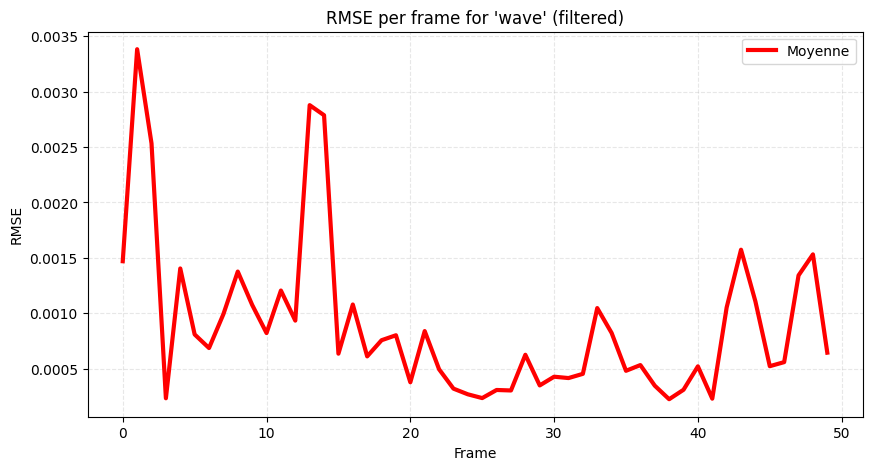

I0000 00:00:1765095508.078333    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.00113841]), array([[0.00146932, 0.00338405, 0.00253365, 0.00023168, 0.0014039 ,
        0.00080819, 0.00068529, 0.00099145, 0.00137593, 0.00107503,
        0.00082063, 0.00120461, 0.00093288, 0.00287885, 0.00278798,
        0.00063444, 0.00107856, 0.00061005, 0.00075585, 0.00080074,
        0.00037591, 0.00083847, 0.00049345, 0.00031866, 0.0002674 ,
        0.00023335, 0.00030649, 0.00030203, 0.00062447, 0.00034773,
        0.00042631, 0.00041412, 0.00045219, 0.00104623, 0.0008215 ,
        0.00047973, 0.00053152, 0.00034546, 0.00022301, 0.00030842,
        0.00052001, 0.00022792, 0.00105154, 0.00157349, 0.00110616,
        0.00052138, 0.00055802, 0.00134133, 0.00153125, 0.0006434 ]]), <__main__.DMPVector object at 0x7df5f920a6e0>, array([[[-0.5647464 ,  0.34548532, -0.02595847, ...,  0.28736874,
         -1.22318293, -0.2868368 ],
        [-0.54316138,  0.36484112, -0.06615681, ...,  0.35552507,
         -1.22965303, -0.2919186 ],
        [-0.53349835,  0.36896497, -0.091847

I0000 00:00:1765095508.079567  290583 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/77 [00:00<?, ?it/s]W0000 00:00:1765095508.123242  290566 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765095508.149307  290567 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 77/77 [00:01<00:00, 41.76it/s]
I0000 00:00:1765095509.950583    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765095509.951548  290634 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/52 [00:00<?, ?it/s]W0000 00:00:1765095509.995114  290616 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip GESRes_filtered_gestures/show/1805_Lecturer2_show.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/42 [00:00<?, ?it/s]W0000 00:00:1765095583.725328  293184 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765095583.753276  293189 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 42/42 [00:00<00:00, 44.91it/s]
I0000 00:00:1765095584.631439    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765095584.632416  293249 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/61 [00:00<?, ?it/s]W0000 00:00:1765095584.680194  293232 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765095584.706138  293243 inference_feedback_ma

KeyboardInterrupt: 

In [41]:
def analyse_full_DESRes(): 
    for i in labels_DESRes:
        print(analyse_label_filtered(i, n=100, target_len=50, n_basis=30)) 
    
analyse_full_DESRes()

I0000 00:00:1765095625.720319    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765095625.721991  294023 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765095625.773023  294009 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765095625.798910  294016 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.67it/s]
I0000 00:00:1765095626.635403    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765095626.636328  294074 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Stop Sign/102427.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765095648.100788  295249 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765095648.156507  295232 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765095648.173863  295241 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.86it/s]
I0000 00:00:1765095649.041716    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765095649.043537  295301 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765095649.099525  295283 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Stop Sign/26116.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765095652.853510  295507 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765095652.923869  295491 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765095652.947921  295500 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 38.17it/s]
I0000 00:00:1765095653.859445    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765095653.860706  295558 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765095653.912230  295545 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Stop Sign/113189.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765095680.761838  297021 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765095680.787672  297033 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.91it/s]
I0000 00:00:1765095681.611414    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765095681.612270  297090 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765095681.657822  297074 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765095681.686039  297079 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Stop Sign/40346.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765095716.843232  299035 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765095716.910831  299022 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765095716.945615  299018 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.77it/s]
I0000 00:00:1765095717.798765    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765095717.799796  299086 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765095717.844873  299072 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Stop Sign/87110.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765095725.110909  299494 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765095725.153118  299477 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765095725.183123  299486 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.05it/s]
I0000 00:00:1765095726.055435    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765095726.057375  299545 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765095726.109032  299527 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Stop Sign/144898.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765095795.444733  303331 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765095795.491101  303318 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765095795.516810  303323 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.01it/s]
I0000 00:00:1765095796.347579    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765095796.349108  303382 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765095796.404898  303367 inference_feedback_manager.cc:114] Feedba


🔎 Stop Sign : 194 videos loaded
📊 Mean RMSE (filtered)  : 0.4112
📈 RMSE max : 0.9698
🧹 Filtrage : 112/194 vidéos gardées (< 0.35)

📊 Mean RMSE (filtered) : 0.16238362985032806
📈 RMSE max : 0.47123184679863467
📉 RMSE min : 0.06366586093848985


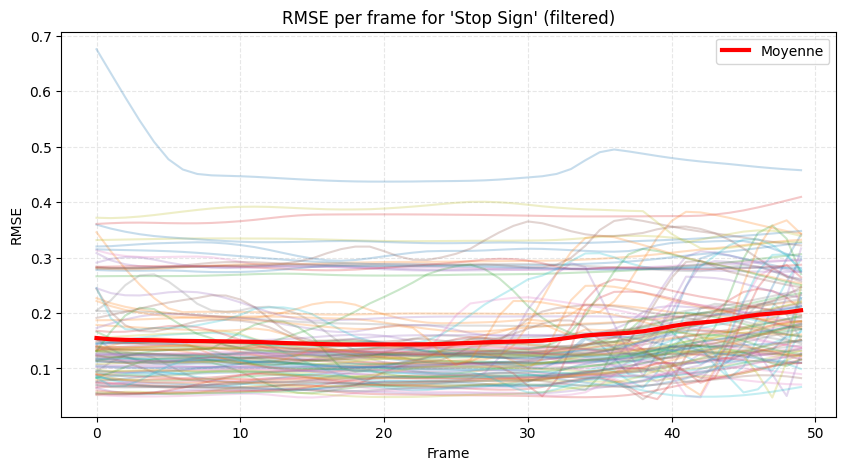

I0000 00:00:1765095812.451522    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.13763502, 0.2566827 , 0.13206927, 0.06366586, 0.16724252,
       0.13758489, 0.11955621, 0.19333737, 0.07629639, 0.12220909,
       0.47123185, 0.19879715, 0.10397065, 0.11057143, 0.2817883 ,
       0.16055331, 0.09608462, 0.13180629, 0.09943689, 0.0918294 ,
       0.16210907, 0.18874263, 0.17509056, 0.09624532, 0.16667035,
       0.14692089, 0.28804942, 0.15739502, 0.13921029, 0.1082346 ,
       0.09879337, 0.29700236, 0.11966526, 0.13674323, 0.16714265,
       0.14849886, 0.09333486, 0.13749109, 0.11806067, 0.11880404,
       0.31554424, 0.16180002, 0.27487617, 0.14301694, 0.07445008,
       0.1203484 , 0.12353759, 0.09404407, 0.13800437, 0.14374604,
       0.29936132, 0.17059242, 0.12340254, 0.1458591 , 0.14696579,
       0.088124  , 0.10933331, 0.13475561, 0.13918309, 0.07982832,
       0.09709546, 0.14427969, 0.1290728 , 0.08850004, 0.14297831,
       0.08249935, 0.15012236, 0.0942169 , 0.33141501, 0.09040883,
       0.33273638, 0.20904451, 0.12280341, 0.1694431 , 0.1362

I0000 00:00:1765095812.452398  304252 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765095812.496193  304238 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765095812.523520  304246 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.43it/s]
I0000 00:00:1765095813.350988    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765095813.352245  304303 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765095813.402943  304287 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Drumming Fingers/139396.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765095821.659471  304762 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765095821.715412  304747 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765095821.744793  304752 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.39it/s]
I0000 00:00:1765095822.623640    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765095822.625100  304813 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765095822.671470  304798 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Drumming Fingers/82571.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765095838.855688  305665 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765095838.879233  305674 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.77it/s]
I0000 00:00:1765095839.723575    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765095839.724440  305734 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765095839.765230  305721 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765095839.793958  305727 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Drumming Fingers/56069.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765095854.838388    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765095854.839591  306550 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765095854.885419  306534 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765095854.924479  306544 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.78it/s]
I0000 00:00:1765095855.759302    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765095855.760257  306601 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Drumming Fingers/54545.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765095875.286776  307669 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765095875.314516  307675 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.28it/s]
I0000 00:00:1765095876.148651    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765095876.149554  307731 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765095876.198732  307723 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765095876.227007  307722 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Drumming Fingers/64510.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765095912.560263  309724 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765095912.605766  309709 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765095912.633535  309711 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:01<00:00, 35.73it/s]
I0000 00:00:1765095913.618484    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765095913.619445  309775 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765095913.666003  309759 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Drumming Fingers/100001.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765095926.652868    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765095926.654128  310490 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765095926.705348  310474 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765095926.742126  310475 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.89it/s]
I0000 00:00:1765095927.597924    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765095927.600171  310541 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Drumming Fingers/71137.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765095943.497373    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/37 [00:00<?, ?it/s]I0000 00:00:1765095943.498197  311411 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765095943.543770  311406 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765095943.573282  311402 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.65it/s]
I0000 00:00:1765095944.433142    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765095944.434270  311462 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Drumming Fingers/50846.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765095969.967232  312842 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765095970.019970  312830 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765095970.043023  312831 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.15it/s]
I0000 00:00:1765095970.903092    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765095970.904331  312893 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765095970.958406  312878 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Drumming Fingers/131375.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765095986.940719  313751 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765095986.969289  313760 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.13it/s]
I0000 00:00:1765095987.799115    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765095987.800273  313815 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765095987.850322  313799 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765095987.876114  313806 inference_feedback_ma


🔎 Drumming Fingers : 191 videos loaded
📊 Mean RMSE (filtered)  : 0.4400
📈 RMSE max : 1.2545
🧹 Filtrage : 87/191 vidéos gardées (< 0.35)

📊 Mean RMSE (filtered) : 0.14888399863470997
📈 RMSE max : 0.49949236449516327
📉 RMSE min : 0.059808124687069725


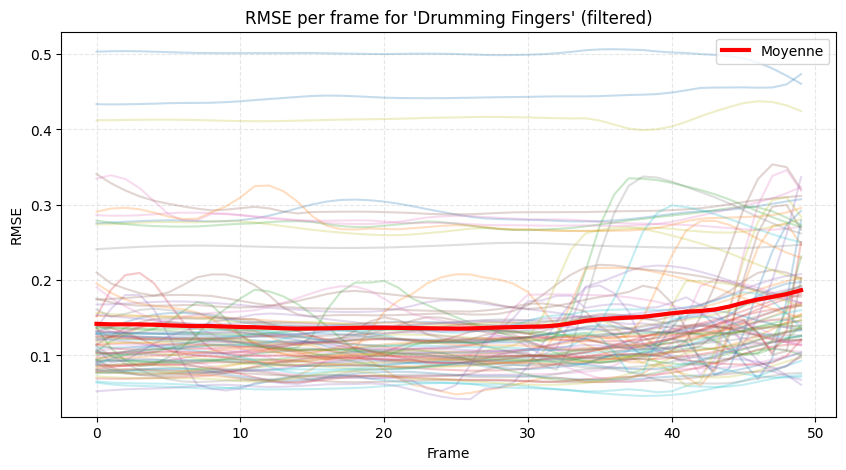

I0000 00:00:1765096000.307723    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096000.308664  314481 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)


(array([0.28822058, 0.1057881 , 0.13064301, 0.10586696, 0.09000666,
       0.14559945, 0.11261798, 0.10047806, 0.08725237, 0.08619112,
       0.14977719, 0.15298387, 0.10222245, 0.13313586, 0.15244417,
       0.07213225, 0.10627826, 0.10762214, 0.26900882, 0.06202576,
       0.07625455, 0.13320359, 0.13904098, 0.10311737, 0.1516238 ,
       0.18087565, 0.27938138, 0.08708776, 0.15234047, 0.05980812,
       0.12513296, 0.14438858, 0.27689998, 0.11870846, 0.12302348,
       0.09240498, 0.09591956, 0.24483131, 0.41502988, 0.10101009,
       0.12522198, 0.11960562, 0.09452052, 0.11268113, 0.12369351,
       0.16888235, 0.14518418, 0.13603164, 0.13279325, 0.12228652,
       0.13574525, 0.11975382, 0.11764699, 0.07916802, 0.15058786,
       0.18443728, 0.28692893, 0.18409635, 0.16713181, 0.14346307,
       0.11417709, 0.11461491, 0.10848609, 0.10456781, 0.11642991,
       0.29665046, 0.108026  , 0.13957439, 0.1238091 , 0.09503619,
       0.49949236, 0.1569067 , 0.19563126, 0.10724549, 0.1470

  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096000.351930  314463 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096000.377400  314475 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 44.57it/s]
I0000 00:00:1765096001.161180    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096001.162062  314533 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096001.214762  314520 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096001.240923  314526 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Thumb Up/140878.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096021.903535  315640 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096021.936438  315651 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.26it/s]
I0000 00:00:1765096022.802654    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096022.804234  315709 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096022.858996  315691 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096022.887049  315701 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Thumb Up/139698.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765096076.490846  318681 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096076.540983  318663 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096076.570640  318674 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.85it/s]
I0000 00:00:1765096077.444121    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096077.445296  318732 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096077.488631  318715 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Thumb Up/16305.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765096085.933899  319192 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096085.984343  319175 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096086.007930  319181 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.91it/s]
I0000 00:00:1765096086.841700    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096086.842828  319243 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096086.879757  319228 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Thumb Up/88087.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765096099.994431  319958 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096100.046963  319944 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096100.074581  319948 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 38.05it/s]
I0000 00:00:1765096101.006809    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096101.008820  320009 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096101.068037  319995 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Thumb Up/63159.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765096135.972827  321958 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096136.033219  321941 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096136.065465  321950 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 38.83it/s]
I0000 00:00:1765096136.954070    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096136.955100  322009 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096136.995438  322000 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Thumb Up/57001.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096138.911860  322093 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096138.937316  322105 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 38.77it/s]
I0000 00:00:1765096139.845782    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096139.847103  322162 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096139.896590  322147 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096139.922473  322150 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Thumb Up/147639.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096161.972013  323369 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096162.001917  323377 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.15it/s]
I0000 00:00:1765096162.902666    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096162.903805  323437 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096162.956304  323420 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096162.983821  323431 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Thumb Up/29625.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765096167.147968  323693 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096167.195320  323678 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096167.222301  323686 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.45it/s]
I0000 00:00:1765096168.094700    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096168.096137  323744 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096168.141382  323730 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Thumb Up/144623.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096178.555717  324290 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096178.581140  324300 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.91it/s]
I0000 00:00:1765096179.391396    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096179.393382  324358 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096179.448532  324345 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096179.478147  324350 inference_feedback_ma


🔎 Thumb Up : 191 videos loaded
📊 Mean RMSE (filtered)  : 0.4752
📈 RMSE max : 1.5611
🧹 Filtrage : 52/191 vidéos gardées (< 0.35)

📊 Mean RMSE (filtered) : 0.17208909556793578
📈 RMSE max : 0.3384353807131842
📉 RMSE min : 0.09307650107070994


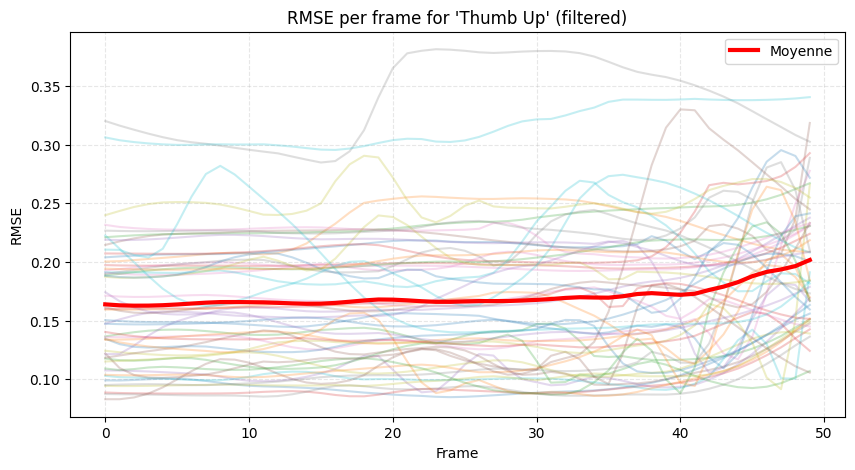

I0000 00:00:1765096186.132591    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.10096048, 0.23095132, 0.13526465, 0.09524957, 0.10833262,
       0.22323334, 0.14398254, 0.0930765 , 0.11649623, 0.10527298,
       0.22065453, 0.14403955, 0.1137646 , 0.19871717, 0.17100223,
       0.12040931, 0.19806499, 0.33843538, 0.10298241, 0.31592607,
       0.13136474, 0.11691569, 0.23564707, 0.21940746, 0.16934073,
       0.12050258, 0.19914828, 0.13236317, 0.1332295 , 0.20246643,
       0.15396924, 0.16152248, 0.20462825, 0.13460022, 0.147793  ,
       0.16988539, 0.16611325, 0.2065182 , 0.19749226, 0.2095608 ,
       0.16013854, 0.13275532, 0.12758684, 0.16595572, 0.21481862,
       0.17885805, 0.22199985, 0.23082338, 0.25272727, 0.18370347,
       0.18809846, 0.20188224]), array([[0.09901092, 0.09889348, 0.09936525, ..., 0.14409947, 0.15077167,
        0.15593286],
       [0.20027936, 0.20063624, 0.20151511, ..., 0.21049861, 0.20909586,
        0.20858852],
       [0.13652226, 0.13838058, 0.14005884, ..., 0.13681948, 0.14407484,
        0.15101148],
       ...,
  

I0000 00:00:1765096186.133777  324722 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096186.199693  324708 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096186.225527  324716 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.71it/s]
I0000 00:00:1765096187.049098    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/37 [00:00<?, ?it/s]I0000 00:00:1765096187.050177  324773 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765096187.091379  324755 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Thumb Down/35536.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096190.560832  324962 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096190.587458  324970 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 43.31it/s]
I0000 00:00:1765096191.399340    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096191.400916  325029 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096191.451183  325012 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096191.478440  325025 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Thumb Down/134364.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096198.976957  325430 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096199.003427  325434 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.64it/s]
I0000 00:00:1765096199.819266    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096199.820264  325492 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096199.864606  325478 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096199.878185  325477 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Thumb Down/13090.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765096202.488221  325647 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096202.534755  325632 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096202.563243  325643 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.54it/s]


⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Thumb Down/128359.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765096203.379737    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096203.380831  325698 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096203.427693  325680 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096203.451055  325691 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.73it/s]
I0000 00:00:1765096204.279684    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096204.281024  325749 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Thumb Down/72107.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096252.879115  328387 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096252.905598  328400 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.14it/s]
I0000 00:00:1765096253.761823    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/37 [00:00<?, ?it/s]I0000 00:00:1765096253.762925  328458 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765096253.812120  328445 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096253.839405  328450 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Thumb Down/133486.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096258.519013  328699 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096258.543874  328703 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.30it/s]
I0000 00:00:1765096259.425874    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096259.427313  328765 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096259.478391  328751 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096259.504412  328756 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Thumb Down/74818.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765096314.866439    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/37 [00:00<?, ?it/s]I0000 00:00:1765096314.867971  331784 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765096314.916616  331772 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096314.946365  331779 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.95it/s]
I0000 00:00:1765096315.772954    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096315.774261  331835 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Thumb Down/29529.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096322.263196  332175 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096322.293598  332183 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.15it/s]
I0000 00:00:1765096323.133560    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/37 [00:00<?, ?it/s]I0000 00:00:1765096323.134503  332244 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765096323.174311  332227 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096323.191233  332236 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Thumb Down/98684.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765096324.997867    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/37 [00:00<?, ?it/s]I0000 00:00:1765096324.999307  332347 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765096325.045311  332331 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096325.074690  332341 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.10it/s]
I0000 00:00:1765096325.976835    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096325.978678  332398 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Thumb Down/19144.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765096333.532499  332806 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096333.586354  332788 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096333.608550  332800 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.61it/s]


⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Thumb Down/32924.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765096334.464321    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096334.465075  332857 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096334.505277  332843 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096334.531815  332847 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.56it/s]
I0000 00:00:1765096335.398647    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096335.399602  332908 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Thumb Down/94995.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765096361.878852  334390 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096361.938934  334375 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096361.970876  334382 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.82it/s]
I0000 00:00:1765096362.806084    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096362.807514  334441 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096362.856363  334429 inference_feedback_manager.cc:114] Feedba


🔎 Thumb Down : 188 videos loaded
📊 Mean RMSE (filtered)  : 0.5252
📈 RMSE max : 1.1321
🧹 Filtrage : 36/188 vidéos gardées (< 0.35)

📊 Mean RMSE (filtered) : 0.15281051994830774
📈 RMSE max : 0.3057768618700591
📉 RMSE min : 0.10102191158391566


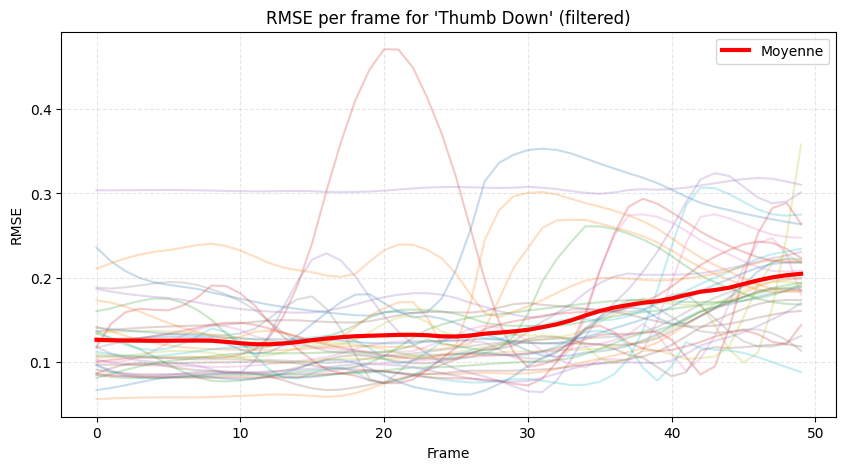

I0000 00:00:1765096372.412438    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.14229331, 0.10546846, 0.15592081, 0.24739459, 0.18305802,
       0.10519859, 0.15984795, 0.14465527, 0.13648449, 0.14989738,
       0.2513289 , 0.20255947, 0.14064902, 0.14302847, 0.18244569,
       0.11049163, 0.15651171, 0.13800547, 0.13467811, 0.10952683,
       0.12175371, 0.17593488, 0.11575236, 0.1626738 , 0.10108665,
       0.11727326, 0.12149554, 0.13068835, 0.13081331, 0.14807573,
       0.14691715, 0.21029121, 0.15984724, 0.10102191, 0.30577686,
       0.15233256]), array([[0.12737202, 0.12758892, 0.12810135, ..., 0.18170755, 0.18468574,
        0.18852355],
       [0.05623247, 0.05712964, 0.05775764, ..., 0.19539551, 0.19800571,
        0.19910876],
       [0.16041589, 0.16385595, 0.16836698, ..., 0.18575218, 0.18815622,
        0.18984242],
       ...,
       [0.08670368, 0.08480271, 0.0836899 , ..., 0.12416805, 0.12160043,
        0.14399793],
       [0.30377282, 0.30362522, 0.30384606, ..., 0.31738657, 0.31404596,
        0.31021933],
       [0.13647646, 0.13812

I0000 00:00:1765096372.413497  334952 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096372.461799  334938 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096372.487986  334937 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.81it/s]
I0000 00:00:1765096373.369338    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096373.370121  335003 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096373.400629  334985 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Turning Hand Counterclockwise/79738.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096379.929183  335349 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096379.956695  335356 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.58it/s]
I0000 00:00:1765096380.816915    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096380.817825  335415 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096380.857287  335401 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096380.891768  335405 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Turning Hand Counterclockwise/77657.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096393.944176  336114 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096393.968985  336124 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 38.18it/s]
I0000 00:00:1765096394.877732    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096394.878669  336181 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096394.924359  336164 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096394.951097  336173 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Turning Hand Counterclockwise/124853.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]I0000 00:00:1765096445.887536  339001 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765096445.951003  338987 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096445.995322  338995 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.22it/s]
I0000 00:00:1765096446.814382    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Turning Hand Counterclockwise/945.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765096446.815659  339052 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096446.867706  339036 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096446.894132  339042 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.70it/s]
I0000 00:00:1765096447.733346    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096447.734662  339103 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096447.781829  339090 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Turning Hand Counterclockwise/46052.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096453.378528  339394 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096453.401839  339396 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.98it/s]
I0000 00:00:1765096454.229764    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096454.231522  339460 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096454.285636  339444 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096454.314411  339453 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Turning Hand Counterclockwise/147017.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765096474.484082  340588 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096474.563333  340575 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096474.585540  340572 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.63it/s]
I0000 00:00:1765096475.383304    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096475.384977  340639 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096475.442336  340623 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Turning Hand Counterclockwise/8176.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765096525.602608  343405 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096525.648494  343388 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096525.678203  343402 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.64it/s]
I0000 00:00:1765096526.578268    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096526.579642  343456 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096526.636000  343441 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Turning Hand Counterclockwise/110913.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096537.676754  344054 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096537.700452  344063 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 45.27it/s]
I0000 00:00:1765096538.474784    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096538.476109  344123 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096538.531073  344105 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096538.558276  344114 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Turning Hand Counterclockwise/12731.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765096540.289667  344226 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096540.360488  344212 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096540.388531  344217 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.30it/s]
I0000 00:00:1765096541.228700    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096541.229504  344277 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096541.274564  344260 inference_feedback_manager.cc:114] Feedba


🔎 Turning Hand Counterclockwise : 191 videos loaded
📊 Mean RMSE (filtered)  : 0.4349
📈 RMSE max : 1.0079
🧹 Filtrage : 88/191 vidéos gardées (< 0.35)

📊 Mean RMSE (filtered) : 0.17644379181082612
📈 RMSE max : 0.4817118007851212
📉 RMSE min : 0.08367233603178804


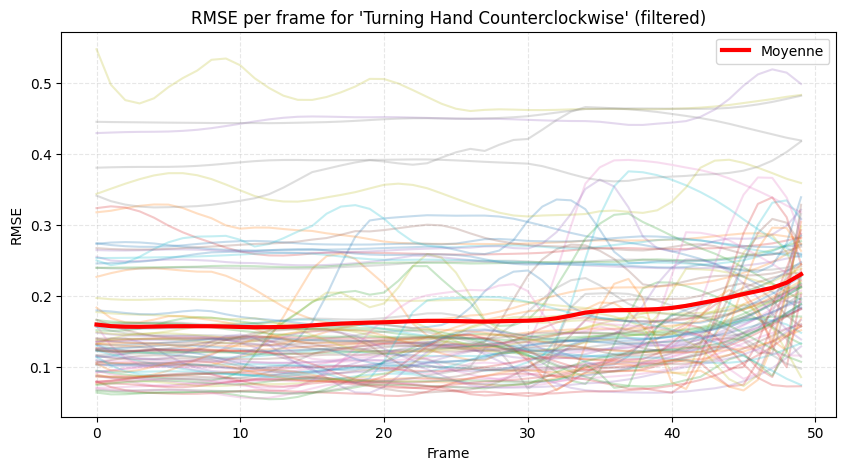

I0000 00:00:1765096558.434066    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.23838702, 0.2894767 , 0.15732245, 0.27207585, 0.24706006,
       0.10209291, 0.23323928, 0.15653199, 0.4817118 , 0.10448755,
       0.27527307, 0.1455299 , 0.1253794 , 0.09757368, 0.12760597,
       0.11169112, 0.09816097, 0.14932921, 0.18431763, 0.21007036,
       0.27082233, 0.20764458, 0.20540826, 0.13106933, 0.10488465,
       0.186236  , 0.11307736, 0.24368568, 0.16552782, 0.14411053,
       0.13729964, 0.14202186, 0.24763612, 0.12460379, 0.13946704,
       0.13977424, 0.11910025, 0.11346706, 0.34657   , 0.27713669,
       0.14385862, 0.15317137, 0.13661125, 0.14489503, 0.45213838,
       0.15367361, 0.1059277 , 0.39985031, 0.1511866 , 0.11837131,
       0.25424796, 0.1373985 , 0.13612413, 0.12303874, 0.27817733,
       0.27450208, 0.16724091, 0.38327694, 0.12860649, 0.25303737,
       0.13085975, 0.15889442, 0.15340926, 0.12041625, 0.12843258,
       0.13565553, 0.15950461, 0.15088749, 0.19046705, 0.14005392,
       0.13144428, 0.10025846, 0.09774011, 0.0972162 , 0.1025

  0%|          | 0/37 [00:00<?, ?it/s]I0000 00:00:1765096558.435014  345198 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765096558.480501  345183 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096558.506853  345190 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.99it/s]
I0000 00:00:1765096559.350156    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/37 [00:00<?, ?it/s]I0000 00:00:1765096559.351844  345249 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765096559.409579  345231 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Turning Hand Clockwise/122007.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765096564.854170  345556 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096564.909984  345547 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096564.938470  345548 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.87it/s]
I0000 00:00:1765096565.798290    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096565.799538  345607 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096565.858314  345590 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Turning Hand Clockwise/21991.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765096624.066447  348827 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096624.130195  348814 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096624.167808  348824 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 43.74it/s]
I0000 00:00:1765096624.938781    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096624.939742  348878 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096624.990739  348872 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Turning Hand Clockwise/58569.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765096630.231926  349184 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096630.280277  349168 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096630.307902  349179 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.14it/s]
I0000 00:00:1765096631.170364    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096631.171545  349235 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096631.219195  349221 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Turning Hand Clockwise/132506.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765096642.342765  349847 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096642.423103  349830 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096642.449046  349842 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 37.53it/s]
I0000 00:00:1765096643.352275    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096643.353453  349898 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096643.402147  349883 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Turning Hand Clockwise/25607.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]I0000 00:00:1765096651.034340  350308 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765096651.088260  350292 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096651.116066  350298 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 38.87it/s]
I0000 00:00:1765096652.028761    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096652.031213  350359 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096652.086678  350341 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Turning Hand Clockwise/89149.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765096653.854556    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/37 [00:00<?, ?it/s]I0000 00:00:1765096653.855631  350462 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765096653.901311  350451 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096653.929412  350446 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.75it/s]
I0000 00:00:1765096654.761415    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/37 [00:00<?, ?it/s]I0000 00:00:1765096654.762971  350513 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: M

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Turning Hand Clockwise/57519.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096661.436182  350854 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096661.461306  350860 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 46.35it/s]
I0000 00:00:1765096662.186705    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096662.188135  350921 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)


⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Turning Hand Clockwise/62993.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096662.235625  350903 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096662.263023  350912 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.20it/s]
I0000 00:00:1765096663.116038    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096663.116990  350972 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096663.161322  350954 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096663.188929  350967 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Turning Hand Clockwise/118299.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096686.266248  352239 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096686.294523  352248 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.09it/s]
I0000 00:00:1765096687.118053    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096687.119420  352308 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096687.172929  352291 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096687.204264  352298 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Turning Hand Clockwise/132417.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765096741.461564  355328 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096741.536120  355313 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096741.561998  355321 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 37.53it/s]
I0000 00:00:1765096742.470897    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096742.471962  355379 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096742.519718  355361 inference_feedback_manager.cc:114] Feedba


🔎 Turning Hand Clockwise : 190 videos loaded
📊 Mean RMSE (filtered)  : 0.4376
📈 RMSE max : 1.0284
🧹 Filtrage : 75/190 vidéos gardées (< 0.35)

📊 Mean RMSE (filtered) : 0.1670072828323947
📈 RMSE max : 0.47214031954025454
📉 RMSE min : 0.06978339972787151


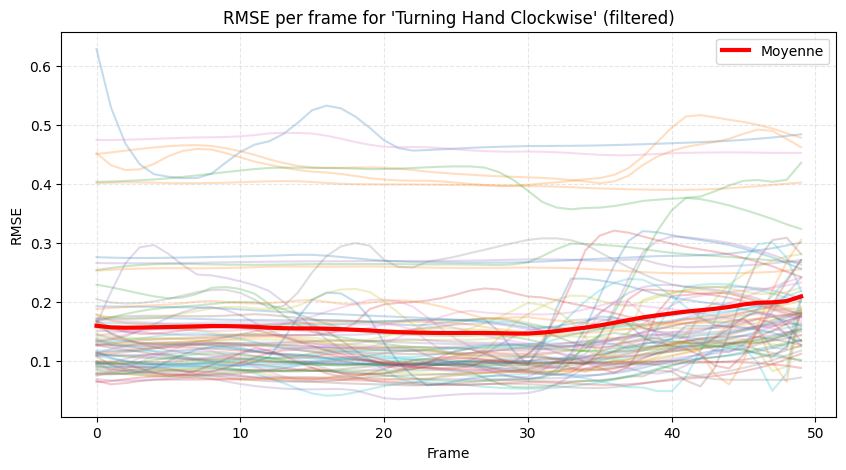

I0000 00:00:1765096743.655499    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096743.656682  355430 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)


(array([0.47214032, 0.12388785, 0.15458096, 0.17137723, 0.19242457,
       0.12830307, 0.13651992, 0.12746761, 0.15756597, 0.11454463,
       0.09632056, 0.4407005 , 0.15709416, 0.10357056, 0.26756033,
       0.11194114, 0.17019288, 0.11900718, 0.14927118, 0.08111144,
       0.17115225, 0.39776823, 0.27080145, 0.12636821, 0.08778875,
       0.12839757, 0.15618135, 0.1334018 , 0.09308576, 0.15079367,
       0.17980697, 0.43925958, 0.09621023, 0.1349637 , 0.13543972,
       0.09666973, 0.14898097, 0.09579678, 0.13782626, 0.1469834 ,
       0.27561583, 0.2557841 , 0.08696264, 0.12028399, 0.193348  ,
       0.1016063 , 0.1543828 , 0.08250934, 0.14039727, 0.14043746,
       0.10366742, 0.16498096, 0.10788753, 0.09533791, 0.15452582,
       0.16189189, 0.46384619, 0.24920125, 0.16669736, 0.12482904,
       0.11300978, 0.18413554, 0.40541885, 0.0697834 , 0.11588905,
       0.11205197, 0.12431746, 0.1355303 , 0.18632954, 0.16904623,
       0.1870222 , 0.1053869 , 0.1941148 , 0.19682367, 0.0792

  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096743.705523  355416 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096743.750803  355427 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.76it/s]
I0000 00:00:1765096744.560699    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096744.561529  355481 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096744.606080  355464 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096744.641655  355472 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Rolling Hand Backward/130951.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096753.989719  355973 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096754.027814  355982 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.31it/s]
I0000 00:00:1765096754.887398    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096754.888597  356042 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096754.932624  356027 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096754.962223  356035 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Rolling Hand Backward/50919.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096796.786573  358334 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096796.819393  358332 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.47it/s]
I0000 00:00:1765096797.671829    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096797.673109  358395 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096797.726789  358377 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096797.749166  358389 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Rolling Hand Backward/132216.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765096832.654807  360337 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096832.706065  360321 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096832.721432  360330 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 44.02it/s]
I0000 00:00:1765096833.524283    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096833.525112  360388 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096833.568880  360372 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Rolling Hand Backward/63026.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765096840.522106  360745 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096840.574614  360729 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096840.600900  360737 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.42it/s]
I0000 00:00:1765096841.451021    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096841.452390  360796 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096841.495889  360778 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Rolling Hand Backward/125976.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096847.096712  361084 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096847.129666  361097 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 45.06it/s]
I0000 00:00:1765096847.885831    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096847.887170  361153 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096847.932143  361137 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096847.951127  361144 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Rolling Hand Backward/91878.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765096852.366862  361409 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096852.417975  361391 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096852.448961  361404 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 38.40it/s]
I0000 00:00:1765096853.359736    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/37 [00:00<?, ?it/s]I0000 00:00:1765096853.360930  361460 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765096853.415676  361448 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Rolling Hand Backward/32141.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096885.804958  363234 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096885.839939  363243 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 43.02it/s]
I0000 00:00:1765096886.641687    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096886.643152  363301 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096886.698463  363283 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096886.709642  363288 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Rolling Hand Backward/78230.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096895.817163  363795 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096895.852595  363803 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 37.41it/s]
I0000 00:00:1765096896.777059    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096896.777877  363863 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096896.807150  363850 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096896.840892  363858 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Rolling Hand Backward/50810.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765096901.513509  364118 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096901.566737  364106 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096901.593252  364109 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 38.56it/s]
I0000 00:00:1765096902.506086    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/37 [00:00<?, ?it/s]I0000 00:00:1765096902.507332  364169 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765096902.559473  364154 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Rolling Hand Backward/88362.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765096918.263340  365040 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096918.303088  365023 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096918.326590  365030 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.96it/s]
I0000 00:00:1765096919.147907    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096919.148858  365091 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096919.189205  365075 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Rolling Hand Backward/70500.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096927.778271  365537 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096927.801232  365545 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.54it/s]
I0000 00:00:1765096928.645146    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096928.646707  365601 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096928.693681  365584 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096928.722912  365595 inference_feedback_ma


🔎 Rolling Hand Backward : 189 videos loaded
📊 Mean RMSE (filtered)  : 0.4206
📈 RMSE max : 0.9852
🧹 Filtrage : 96/189 vidéos gardées (< 0.35)

📊 Mean RMSE (filtered) : 0.1394906130792937
📈 RMSE max : 0.39131796925692536
📉 RMSE min : 0.07390627767803624


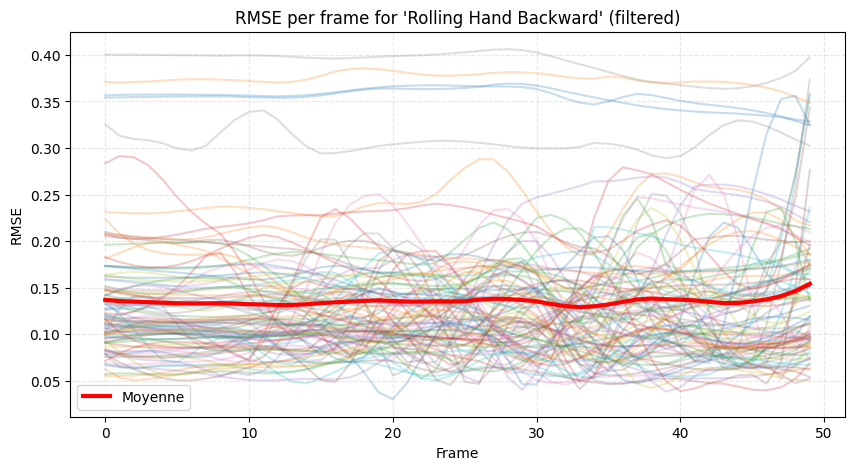

I0000 00:00:1765096929.927311    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


(array([0.09996167, 0.24092904, 0.12676977, 0.09485686, 0.09076916,
       0.07390628, 0.11825973, 0.11989929, 0.16351738, 0.13039382,
       0.14006975, 0.11340478, 0.15428469, 0.15262891, 0.1242079 ,
       0.10474093, 0.09625591, 0.11655166, 0.08900805, 0.10147966,
       0.13955654, 0.19161965, 0.17735836, 0.10753823, 0.16592276,
       0.14869451, 0.14397348, 0.39131797, 0.09968856, 0.1126544 ,
       0.3554661 , 0.09358305, 0.09724819, 0.16732922, 0.08983927,
       0.19467116, 0.11235922, 0.10090139, 0.13791808, 0.08411423,
       0.11414089, 0.3738997 , 0.12870813, 0.11888751, 0.18638758,
       0.08182234, 0.09691964, 0.13483691, 0.1060806 , 0.0976724 ,
       0.35344526, 0.11226928, 0.17513773, 0.15774652, 0.11422901,
       0.17147067, 0.1291967 , 0.12976849, 0.14960032, 0.15628988,
       0.09738414, 0.16947708, 0.15630835, 0.09786949, 0.11546071,
       0.11393771, 0.15786804, 0.30824928, 0.09778261, 0.13707643,
       0.13958409, 0.16761749, 0.13454033, 0.10973275, 0.1311

  0%|          | 0/37 [00:00<?, ?it/s]I0000 00:00:1765096929.929189  365653 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765096929.979739  365642 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096929.992184  365639 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 44.83it/s]
I0000 00:00:1765096930.782999    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096930.783822  365704 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096930.836871  365689 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Rolling Hand Forward/15814.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765096979.759700  368414 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096979.811420  368403 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765096979.840461  368405 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.10it/s]
I0000 00:00:1765096980.693244    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765096980.694872  368465 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765096980.747324  368453 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Rolling Hand Forward/144339.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097005.201913  369779 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097005.227212  369787 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.32it/s]
I0000 00:00:1765097006.088785    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765097006.089748  369845 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097006.143111  369830 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097006.170787  369838 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Rolling Hand Forward/100764.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097008.864984  369982 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097008.893138  369991 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.99it/s]
I0000 00:00:1765097009.739046    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765097009.739846  370049 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097009.779698  370032 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097009.806093  370039 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Rolling Hand Forward/54315.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]I0000 00:00:1765097011.452326  370151 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765097011.496720  370134 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097011.526258  370142 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 43.43it/s]


⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Rolling Hand Forward/20761.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765097012.335335    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765097012.336687  370203 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097012.388097  370188 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097012.414513  370194 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 38.27it/s]
I0000 00:00:1765097013.337277    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765097013.339460  370254 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Rolling Hand Forward/110324.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097043.096296  371881 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097043.128853  371887 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.95it/s]
I0000 00:00:1765097044.007715    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765097044.008738  371941 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097044.061188  371926 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097044.091041  371936 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Rolling Hand Forward/21142.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765097044.899303  371992 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097044.947095  371975 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097044.973559  371983 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.22it/s]
I0000 00:00:1765097045.809105    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765097045.810230  372043 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097045.853741  372025 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Rolling Hand Forward/48030.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765097074.915249  373628 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097074.993731  373611 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097075.019930  373621 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.94it/s]
I0000 00:00:1765097075.844885    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765097075.846268  373679 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097075.879393  373661 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Rolling Hand Forward/74675.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765097100.884206  375062 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097100.972012  375047 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097100.999183  375053 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 38.78it/s]
I0000 00:00:1765097101.872677    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765097101.873814  375113 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097101.913824  375099 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Rolling Hand Forward/100374.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097105.555987  375299 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097105.586063  375307 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.02it/s]
I0000 00:00:1765097106.412456    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765097106.414024  375368 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097106.475400  375352 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097106.487509  375362 inference_feedback_ma


🔎 Rolling Hand Forward : 190 videos loaded
📊 Mean RMSE (filtered)  : 0.3794
📈 RMSE max : 1.0515
🧹 Filtrage : 120/190 vidéos gardées (< 0.35)

📊 Mean RMSE (filtered) : 0.1573638658752853
📈 RMSE max : 0.3657095745905574
📉 RMSE min : 0.09130394035160375


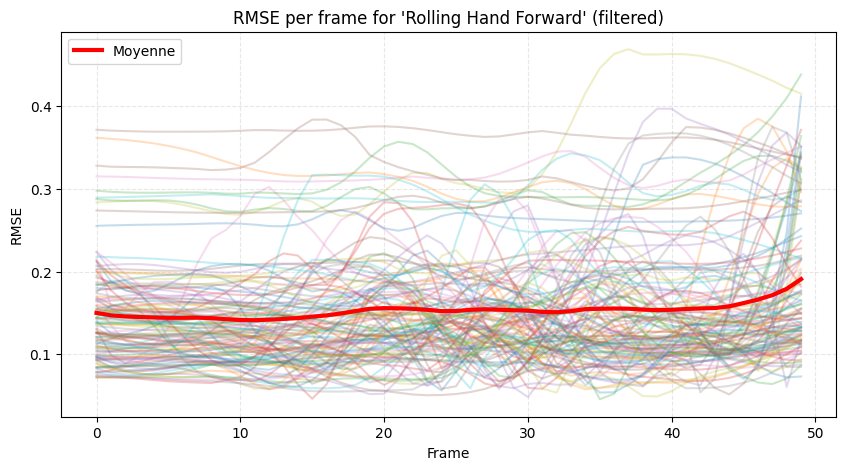

I0000 00:00:1765097116.048612    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765097116.049541  375879 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)


(array([0.18461243, 0.13017277, 0.13694956, 0.10615503, 0.10713191,
       0.18308171, 0.1485137 , 0.15075722, 0.35124159, 0.29689578,
       0.18354891, 0.14817946, 0.12806744, 0.11150948, 0.12018103,
       0.10036262, 0.13383771, 0.09872263, 0.12855049, 0.15424225,
       0.19183728, 0.13751027, 0.15786346, 0.13438937, 0.14167533,
       0.10709371, 0.15860786, 0.22917413, 0.13319943, 0.13102396,
       0.13487961, 0.18166829, 0.13510634, 0.15474161, 0.13580372,
       0.33461633, 0.13153724, 0.12655477, 0.1664333 , 0.14141617,
       0.13419608, 0.16217033, 0.29946336, 0.10536701, 0.13349377,
       0.14463044, 0.17075322, 0.19236801, 0.15683209, 0.09868605,
       0.26134242, 0.12503408, 0.12392939, 0.11700372, 0.09701747,
       0.0974793 , 0.15499892, 0.15374426, 0.09130394, 0.1457409 ,
       0.19281981, 0.31048574, 0.30670113, 0.17866095, 0.1074163 ,
       0.19802807, 0.317222  , 0.12898817, 0.20147586, 0.12873103,
       0.16189601, 0.1064732 , 0.11406161, 0.12524475, 0.2058

  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097116.109733  375862 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097116.141401  375865 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 38.08it/s]
I0000 00:00:1765097117.062637    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765097117.064308  375930 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097117.121468  375912 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097117.147680  375920 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/107561.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765097122.659463  376236 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097122.718889  376220 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097122.740476  376227 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 38.88it/s]
I0000 00:00:1765097123.638767    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765097123.639700  376287 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097123.687634  376269 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/70773.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097139.402568  377142 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097139.433041  377150 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.19it/s]
I0000 00:00:1765097140.271306    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/37 [00:00<?, ?it/s]I0000 00:00:1765097140.272708  377206 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765097140.317077  377192 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097140.345828  377200 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/24168.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765097166.903796  378690 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097166.974945  378672 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097167.005500  378685 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 38.09it/s]
I0000 00:00:1765097167.909502    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765097167.910930  378741 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097167.960807  378725 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/96045.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765097171.621365  378947 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097171.666245  378932 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097171.692668  378940 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 43.87it/s]
I0000 00:00:1765097172.498366    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765097172.499893  378998 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097172.552020  378983 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/82428.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765097174.293308  379100 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097174.350813  379084 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097174.391604  379095 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 38.33it/s]
I0000 00:00:1765097175.294473    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765097175.295631  379151 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097175.331311  379136 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/123465.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097176.279701  379186 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097176.291580  379185 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.40it/s]
I0000 00:00:1765097177.194418    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765097177.195863  379253 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097177.247052  379237 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097177.272197  379247 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/133809.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097181.841594  379495 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097181.871165  379502 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 44.05it/s]
I0000 00:00:1765097182.632475    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765097182.633877  379559 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097182.687309  379544 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097182.701315  379552 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/122197.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097190.137317  379952 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097190.165258  379961 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 38.84it/s]
I0000 00:00:1765097191.050138    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765097191.051431  380020 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097191.102614  380002 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097191.132971  380011 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/97030.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765097194.716963  380224 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097194.764910  380208 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097194.791086  380216 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.28it/s]
I0000 00:00:1765097195.691700    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765097195.693036  380276 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097195.746931  380270 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/42461.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097220.426913  381641 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097220.455266  381640 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.39it/s]
I0000 00:00:1765097221.324004    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765097221.325001  381708 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097221.367965  381694 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097221.398757  381703 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/135912.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097228.835819  382106 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097228.848170  382105 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 38.93it/s]
I0000 00:00:1765097229.762848    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765097229.764738  382167 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097229.819321  382151 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097229.848248  382160 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/60164.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765097240.843818  382780 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097240.891369  382763 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097240.911545  382773 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 44.74it/s]
I0000 00:00:1765097241.695109    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765097241.696021  382831 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097241.743551  382814 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/93585.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097260.863703  383889 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097260.893573  383890 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 43.23it/s]
I0000 00:00:1765097261.668579    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765097261.669996  383955 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097261.720954  383941 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097261.750347  383947 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/31710.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765097289.620732  385496 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097289.674942  385478 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097289.691693  385489 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 43.63it/s]
I0000 00:00:1765097290.488617    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765097290.489416  385547 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097290.532478  385538 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/29639.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097291.449996  385582 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097291.466098  385592 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.51it/s]
I0000 00:00:1765097292.360997    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765097292.362767  385649 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)


⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/128247.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097292.422602  385631 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097292.438689  385644 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.62it/s]
I0000 00:00:1765097293.283868    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765097293.284977  385700 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097293.335280  385684 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097293.359751  385694 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/134758.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097294.333857  385733 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097294.361254  385744 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.07it/s]
I0000 00:00:1765097295.243165    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765097295.244591  385802 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097295.298524  385790 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097295.311070  385795 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Pushing Hand Away/21218.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097300.080838  386040 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097300.106381  386043 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 43.16it/s]



🔎 Pushing Hand Away : 182 videos loaded
📊 Mean RMSE (filtered)  : 0.4770
📈 RMSE max : 1.0797
🧹 Filtrage : 65/182 vidéos gardées (< 0.35)

📊 Mean RMSE (filtered) : 0.18292414395363396
📈 RMSE max : 0.36085146177234456
📉 RMSE min : 0.08212827703621894


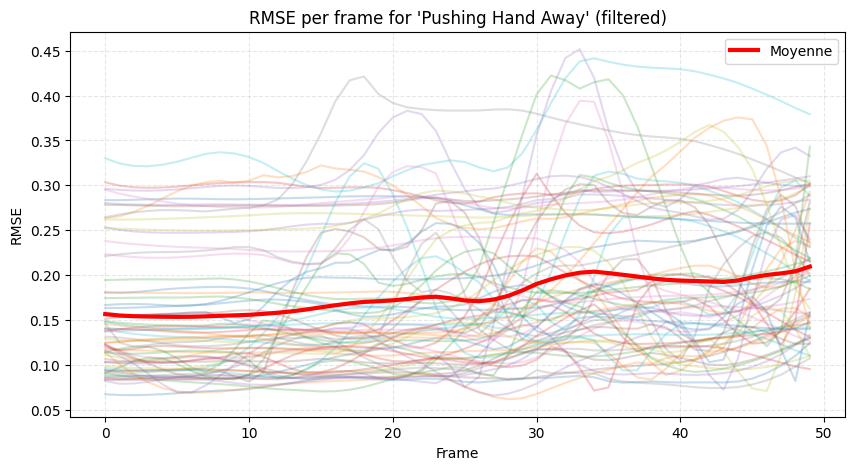

I0000 00:00:1765097301.162292    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765097301.163574  386108 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)


(array([0.17240468, 0.11941606, 0.12080641, 0.29492574, 0.30009512,
       0.17432669, 0.1299331 , 0.19941051, 0.15251525, 0.20684737,
       0.17875906, 0.18483042, 0.18482369, 0.16449892, 0.27480466,
       0.13610409, 0.15244407, 0.13916455, 0.12615839, 0.17705845,
       0.2751325 , 0.28274414, 0.15476732, 0.20243636, 0.22822168,
       0.0967732 , 0.21342962, 0.13179042, 0.11117951, 0.17105861,
       0.08212828, 0.1534192 , 0.14809657, 0.12641691, 0.28886669,
       0.28485645, 0.19143599, 0.08721469, 0.23122666, 0.16006545,
       0.12919127, 0.1422748 , 0.17510806, 0.1217319 , 0.101254  ,
       0.10663266, 0.28477754, 0.34237176, 0.26848023, 0.36085146,
       0.21046318, 0.10789756, 0.24920484, 0.14981321, 0.12683625,
       0.20083075, 0.21719533, 0.18521406, 0.27250693, 0.13950805,
       0.17775047, 0.21261457, 0.16306333, 0.11287941, 0.12103027]), array([[0.16335316, 0.16324232, 0.16371226, ..., 0.27635723, 0.264068  ,
        0.21480968],
       [0.1171801 , 0.1168316 , 

  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097301.223854  386092 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097301.249507  386105 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.30it/s]
I0000 00:00:1765097302.115935    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765097302.117195  386159 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097302.173433  386142 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097302.195779  386148 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Shaking Hand/57241.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765097313.939625  386823 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097313.996099  386811 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097314.024960  386809 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.11it/s]
I0000 00:00:1765097314.888082    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5


⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Shaking Hand/54187.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765097314.889606  386874 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097314.994944  386856 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097315.019578  386865 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.58it/s]
I0000 00:00:1765097315.799475    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765097315.800314  386925 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097315.854807  386909 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Shaking Hand/53698.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097363.184804  389514 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097363.213002  389521 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 44.97it/s]
I0000 00:00:1765097363.986390    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765097363.987546  389582 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097364.031977  389566 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097364.057352  389574 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Shaking Hand/65514.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765097378.056222    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/37 [00:00<?, ?it/s]I0000 00:00:1765097378.057435  390348 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765097378.108909  390331 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097378.131085  390338 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.26it/s]
I0000 00:00:1765097379.022596    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765097379.024257  390399 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Shaking Hand/81385.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765097381.917986  390552 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097381.964163  390543 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097381.988248  390547 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.73it/s]
I0000 00:00:1765097382.876716    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/37 [00:00<?, ?it/s]I0000 00:00:1765097382.877938  390603 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765097382.929524  390588 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Shaking Hand/110713.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765097389.300498  390962 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097389.350584  390945 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097389.373347  390955 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.29it/s]
I0000 00:00:1765097390.220152    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765097390.220920  391013 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097390.271866  390999 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Shaking Hand/90325.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097398.754200  391462 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097398.781176  391469 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.77it/s]
I0000 00:00:1765097399.668938    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765097399.670680  391527 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097399.718536  391509 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097399.744691  391520 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Shaking Hand/102593.mp4 : AttributeError("'list' object has no attribute 'shape'")


  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097413.639236  392284 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097413.665787  392285 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.45it/s]
I0000 00:00:1765097414.510820    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
  0%|          | 0/37 [00:00<?, ?it/s]I0000 00:00:1765097414.512283  392343 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
W0000 00:00:1765097414.569628  392337 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097414.591485  392334 inference_feedback_ma

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Shaking Hand/5315.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765097424.805647  392906 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097424.873634  392889 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097424.909455  392899 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 40.43it/s]
I0000 00:00:1765097425.740610    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765097425.741718  392957 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097425.791252  392945 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Shaking Hand/17.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765097433.139937  393367 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097433.201528  393361 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097433.229193  393359 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 39.71it/s]
I0000 00:00:1765097434.102694    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765097434.104022  393419 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097434.150132  393405 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Shaking Hand/146190.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765097477.125534  395770 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097477.170188  395756 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097477.196265  395765 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 41.91it/s]
I0000 00:00:1765097478.035241    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765097478.036707  395821 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097478.111503  395806 inference_feedback_manager.cc:114] Feedba

⚠️ landmarks_2_table failed: AttributeError("'NoneType' object has no attribute 'landmark'")
Returning raw BlazePose outputs.
⚠️ Skip Jester_filtered_gestures/Shaking Hand/132392.mp4 : AttributeError("'list' object has no attribute 'shape'")


I0000 00:00:1765097484.448756    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765097484.450283  396178 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|          | 0/37 [00:00<?, ?it/s]W0000 00:00:1765097484.517344  396162 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1765097484.547303  396173 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 37/37 [00:00<00:00, 42.03it/s]
I0000 00:00:1765097485.371379    4735 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1765097485.372714  396229 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) Graphics (RPL-P)
  0%|   


🔎 Shaking Hand : 188 videos loaded
📊 Mean RMSE (filtered)  : 0.3469
📈 RMSE max : 0.9687
🧹 Filtrage : 133/188 vidéos gardées (< 0.35)

📊 Mean RMSE (filtered) : 0.16484577771469078
📈 RMSE max : 0.43028423782560354
📉 RMSE min : 0.07245768376370107


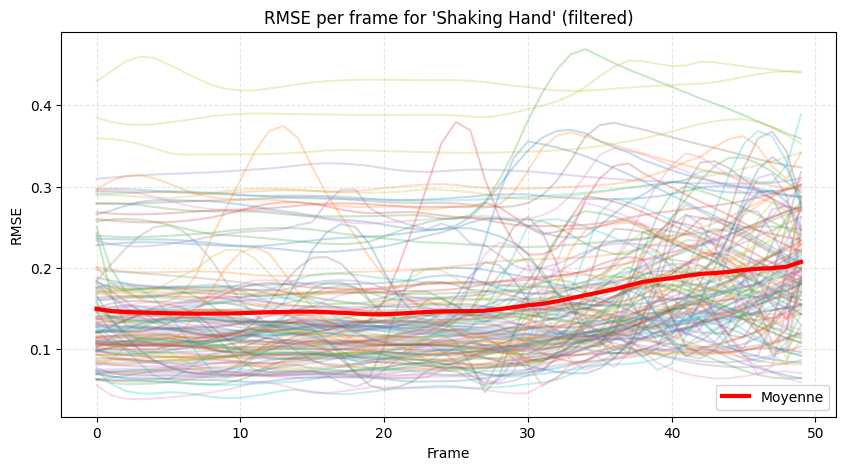

(array([0.11256461, 0.1351253 , 0.14629773, 0.26326052, 0.10266885,
       0.13832026, 0.14942432, 0.13476908, 0.14221014, 0.09469189,
       0.13348856, 0.16527159, 0.2388536 , 0.15619821, 0.31549251,
       0.14447119, 0.10003487, 0.09316739, 0.11781338, 0.12722839,
       0.14018833, 0.21694291, 0.17179278, 0.14239895, 0.16339383,
       0.14847879, 0.16309675, 0.14149739, 0.40768735, 0.1696617 ,
       0.29016413, 0.12742998, 0.25909074, 0.17782858, 0.14436967,
       0.16338394, 0.1390462 , 0.1112257 , 0.29853614, 0.29597608,
       0.25270039, 0.09955096, 0.11806553, 0.10779286, 0.16398825,
       0.12449039, 0.18959797, 0.14799904, 0.11609019, 0.08285866,
       0.29492639, 0.18075061, 0.1054064 , 0.10309724, 0.10925242,
       0.13940743, 0.1184139 , 0.14711338, 0.12750308, 0.19391338,
       0.14459199, 0.30643318, 0.20068069, 0.19142074, 0.08341652,
       0.30774031, 0.09951786, 0.15282736, 0.43028424, 0.12059486,
       0.09981892, 0.1074407 , 0.18441768, 0.12825957, 0.1340

In [42]:
def analyse_full_jester(): 
    for i in labels_jester:
        print(analyse_label_filtered(i, n = 200, target_len=50, n_basis=30)) 
    
analyse_full_jester()